In [6]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Index
- [First exploratory analysis](#First-exploratory-analysis)
    - [Add some useful columns](#Add-some-useful-columns)
    - [Check number of active cars](#Check-number-of-active-cars)
    - [A glance on the distributions of speed and cars number](#A-glance-on-the-distributions-of-speed-and-cars-number)
    - [Speed and cars number together](#Speed-and-cars-number-together)
- [Building the grid](#Building-the-grid)

# First exploratory analysis

In [7]:
# LOAD THE TURIN FILE. This may take a while

turin_file_path = 'turin_june.csv'
turin_june = pd.read_csv(turin_file_path, parse_dates=['recording_date'])

In [8]:
print("We've got %d different cars" %turin_june.device_id.nunique())

We've got 20158 different cars


In [9]:
print('The dataset timestamp range goes from %s to %s' %(
    str(turin_june.recording_date.min()), str(turin_june.recording_date.max())))

The dataset timestamp range goes from 2017-06-01 00:00:00 to 2017-06-30 21:59:49


### Add some useful columns
- `day`: UTC date without the time stamp
- `day_of_the_week`: day of the week encoded as an integer (Monday = 1)
- `hour`: only the hour of recording
- `hour_and_half`: the time stamp floored to the nearest hour and half. For instance, 11:32 would become 11:30 and 11:27 would become 11:000

In [10]:
from datetime import time

turin_june['day'] = turin_june.recording_date.dt.date
turin_june['day_of_the_week'] = turin_june.recording_date.dt.weekday + 1
turin_june['hour'] = turin_june.recording_date.dt.hour
turin_june['hour_half'] = turin_june.recording_date.dt.time.apply(lambda t: time(t.hour, (t.minute // 30)*30))

### Check number of active cars

Creating a plot for the number of active cars in each day of june. The figure will be saved under the chosen `figurepath` and its size is determined by the `fig_size` tuple

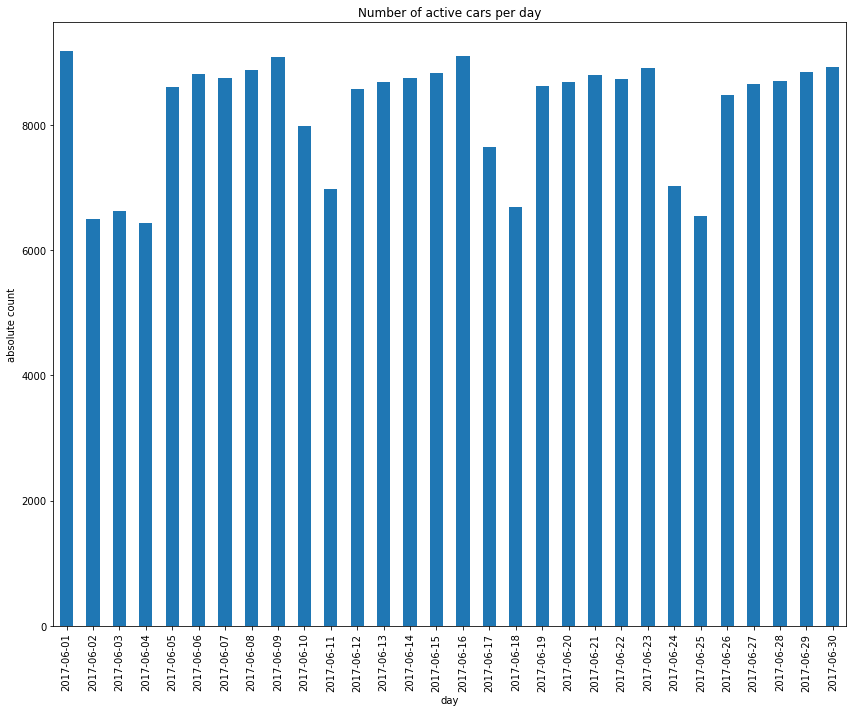

In [11]:
figurepath = 'active_cars.png'
fig_size = (12, 10)

ax = turin_june[turin_june.engine_status == 1].groupby('day').agg({'device_id': 'nunique'})\
.plot(kind='bar',  figsize=fig_size, title='Number of active cars per day')

ax.legend_.remove()
plt.ylabel('absolute count')
plt.tight_layout()
plt.savefig(figurepath)

### A glance on the distributions of speed and cars number

We first define an utility functions that plots the distributions of speed aggrageted by the desired timestamp (it can be hours, weekday or hour and half)

In [29]:
def avg_speed_dist(data, mode='hour', plotting=True):
    """Plots the histogram of speed values aggregated by the time stamp specified in the mode parameter.
    Also returns the median and average values.
    :param data: pandas DataFrame; the input dataset
    :param mode: string; the kind of time stamp according to wich aggregating the values. Possible modes:
    'hour', 'weekday', 'hour_half'
    :param plotting: boolean; to have the plots as output or not
    :return : tuple of 2 lists; the first are the medians, the second the means"""

    medians = []
    avgs = []

    if mode == 'hour':
        fig = plt.figure(figsize=(20, 30));
        axes = fig.subplots(6, 4);
        for h in range(0, 24, 1):
            i = int(h/4)
            j = h%4
            df = data[data.hour == h].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                df.plot(kind='hist', title='Avg speed at %d:00' % h, ax=axes[i, j], bins=15)
    elif mode == 'weekday':
        fig = plt.figure(figsize=(10, 30));
        axes = fig.subplots(4, 2);
        for d in range(1, 8):
            i = int((d-1)/2)
            j = (d-1)%2
            df = data[data.day_of_the_week == d].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                df.plot(kind='hist', title='Avg speed at day %d of the week' % d, ax=axes[i, j], bins=15)
                
    elif mode == 'hour_half':
        fig = plt.figure(figsize=(10, 40));
        axes = fig.subplots(12, 4);
        for n, hh in enumerate(sorted(data.hour_half.unique())):
            i = int((n - 1) / 4)
            j = (n - 1)%4
            df = data[data['hour_half'] == hh].groupby('device_id').agg({'speed': np.mean})
            medians.append(df.speed.quantile(0.5))
            avgs.append(df.speed.mean())
        
            if plotting:
                df.plot(kind='hist', title='Avg speed at %s' % str(hh), ax=axes[i, j], bins=15)
            
    if plotting:
        plt.tight_layout()
        plt.show()
    return medians, avgs

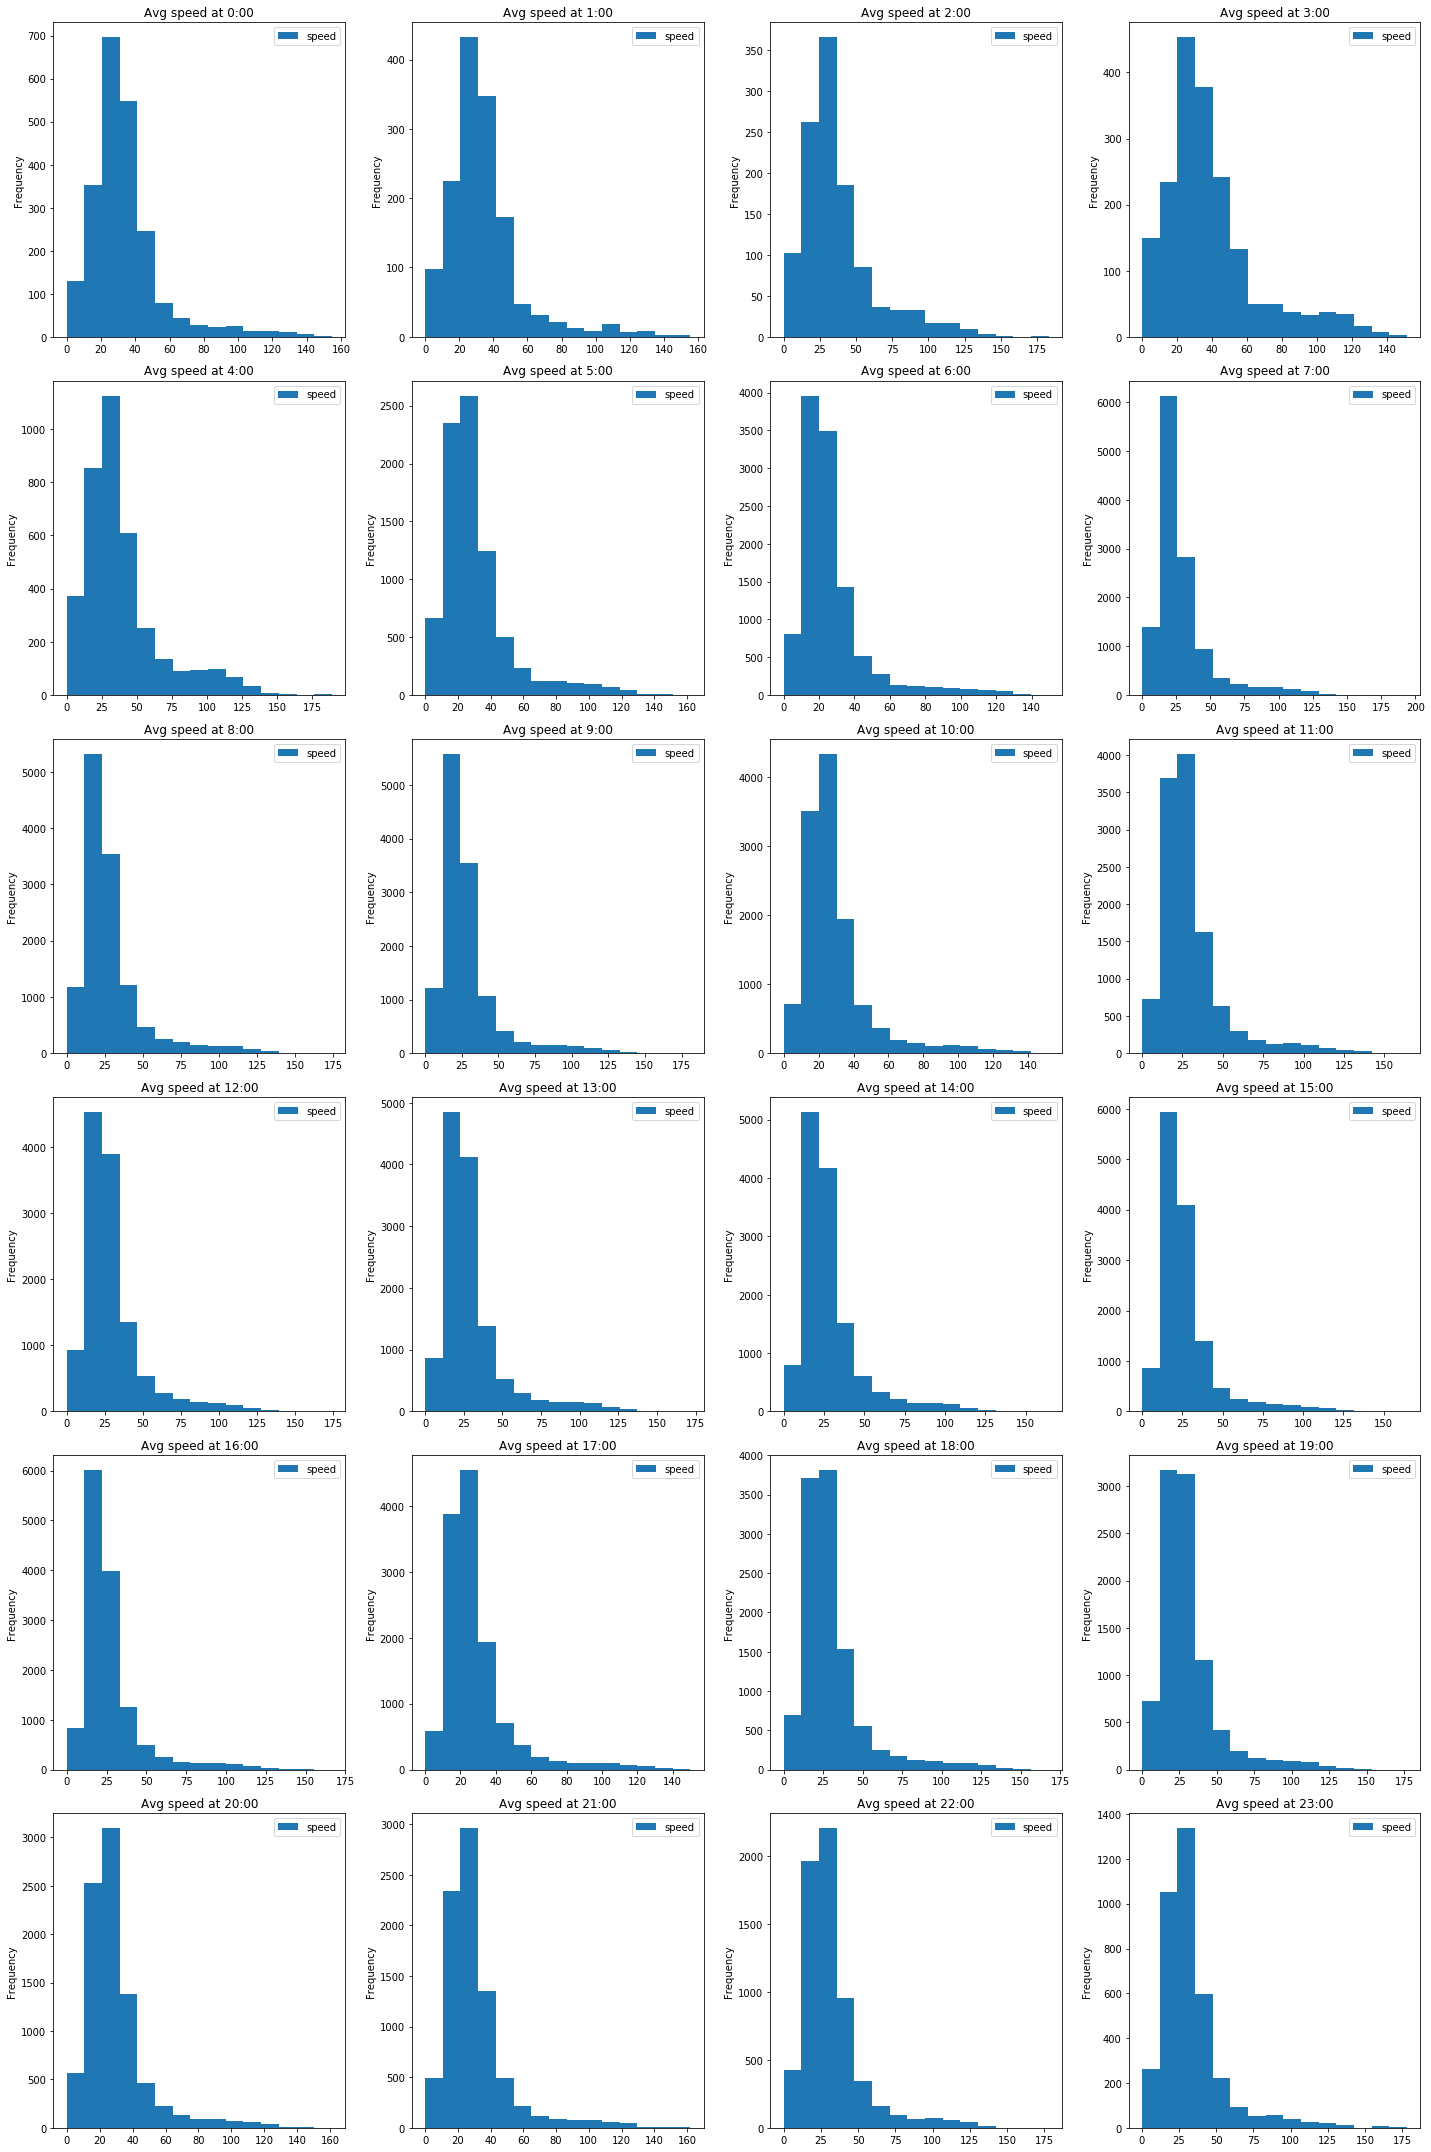

In [13]:
## See average speed by hour of the day, weekends included

medians, avgs = avg_speed_dist(turin_june[turin_june.engine_status == 1])

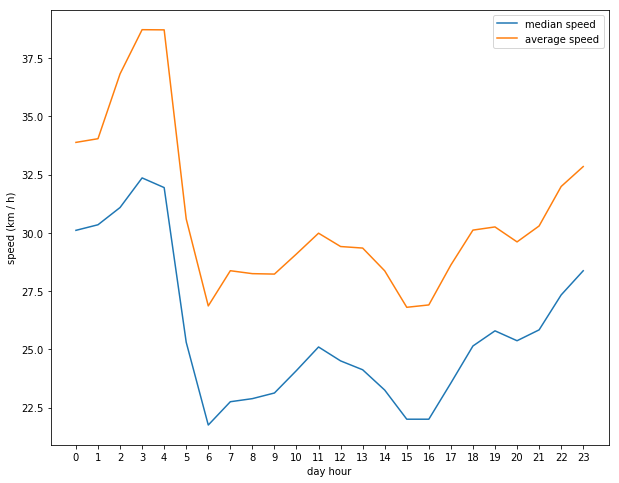

In [14]:
## Plot median and average of speed distribution by hour of the day

plt.figure(figsize=(10, 8))
plt.plot(range(0, 24), medians, label='median speed')
plt.plot(range(0, 24), avgs, label='average speed')
plt.xticks(range(0, 24))
plt.xlabel('day hour')
plt.ylabel('speed (km / h)')
plt.legend()

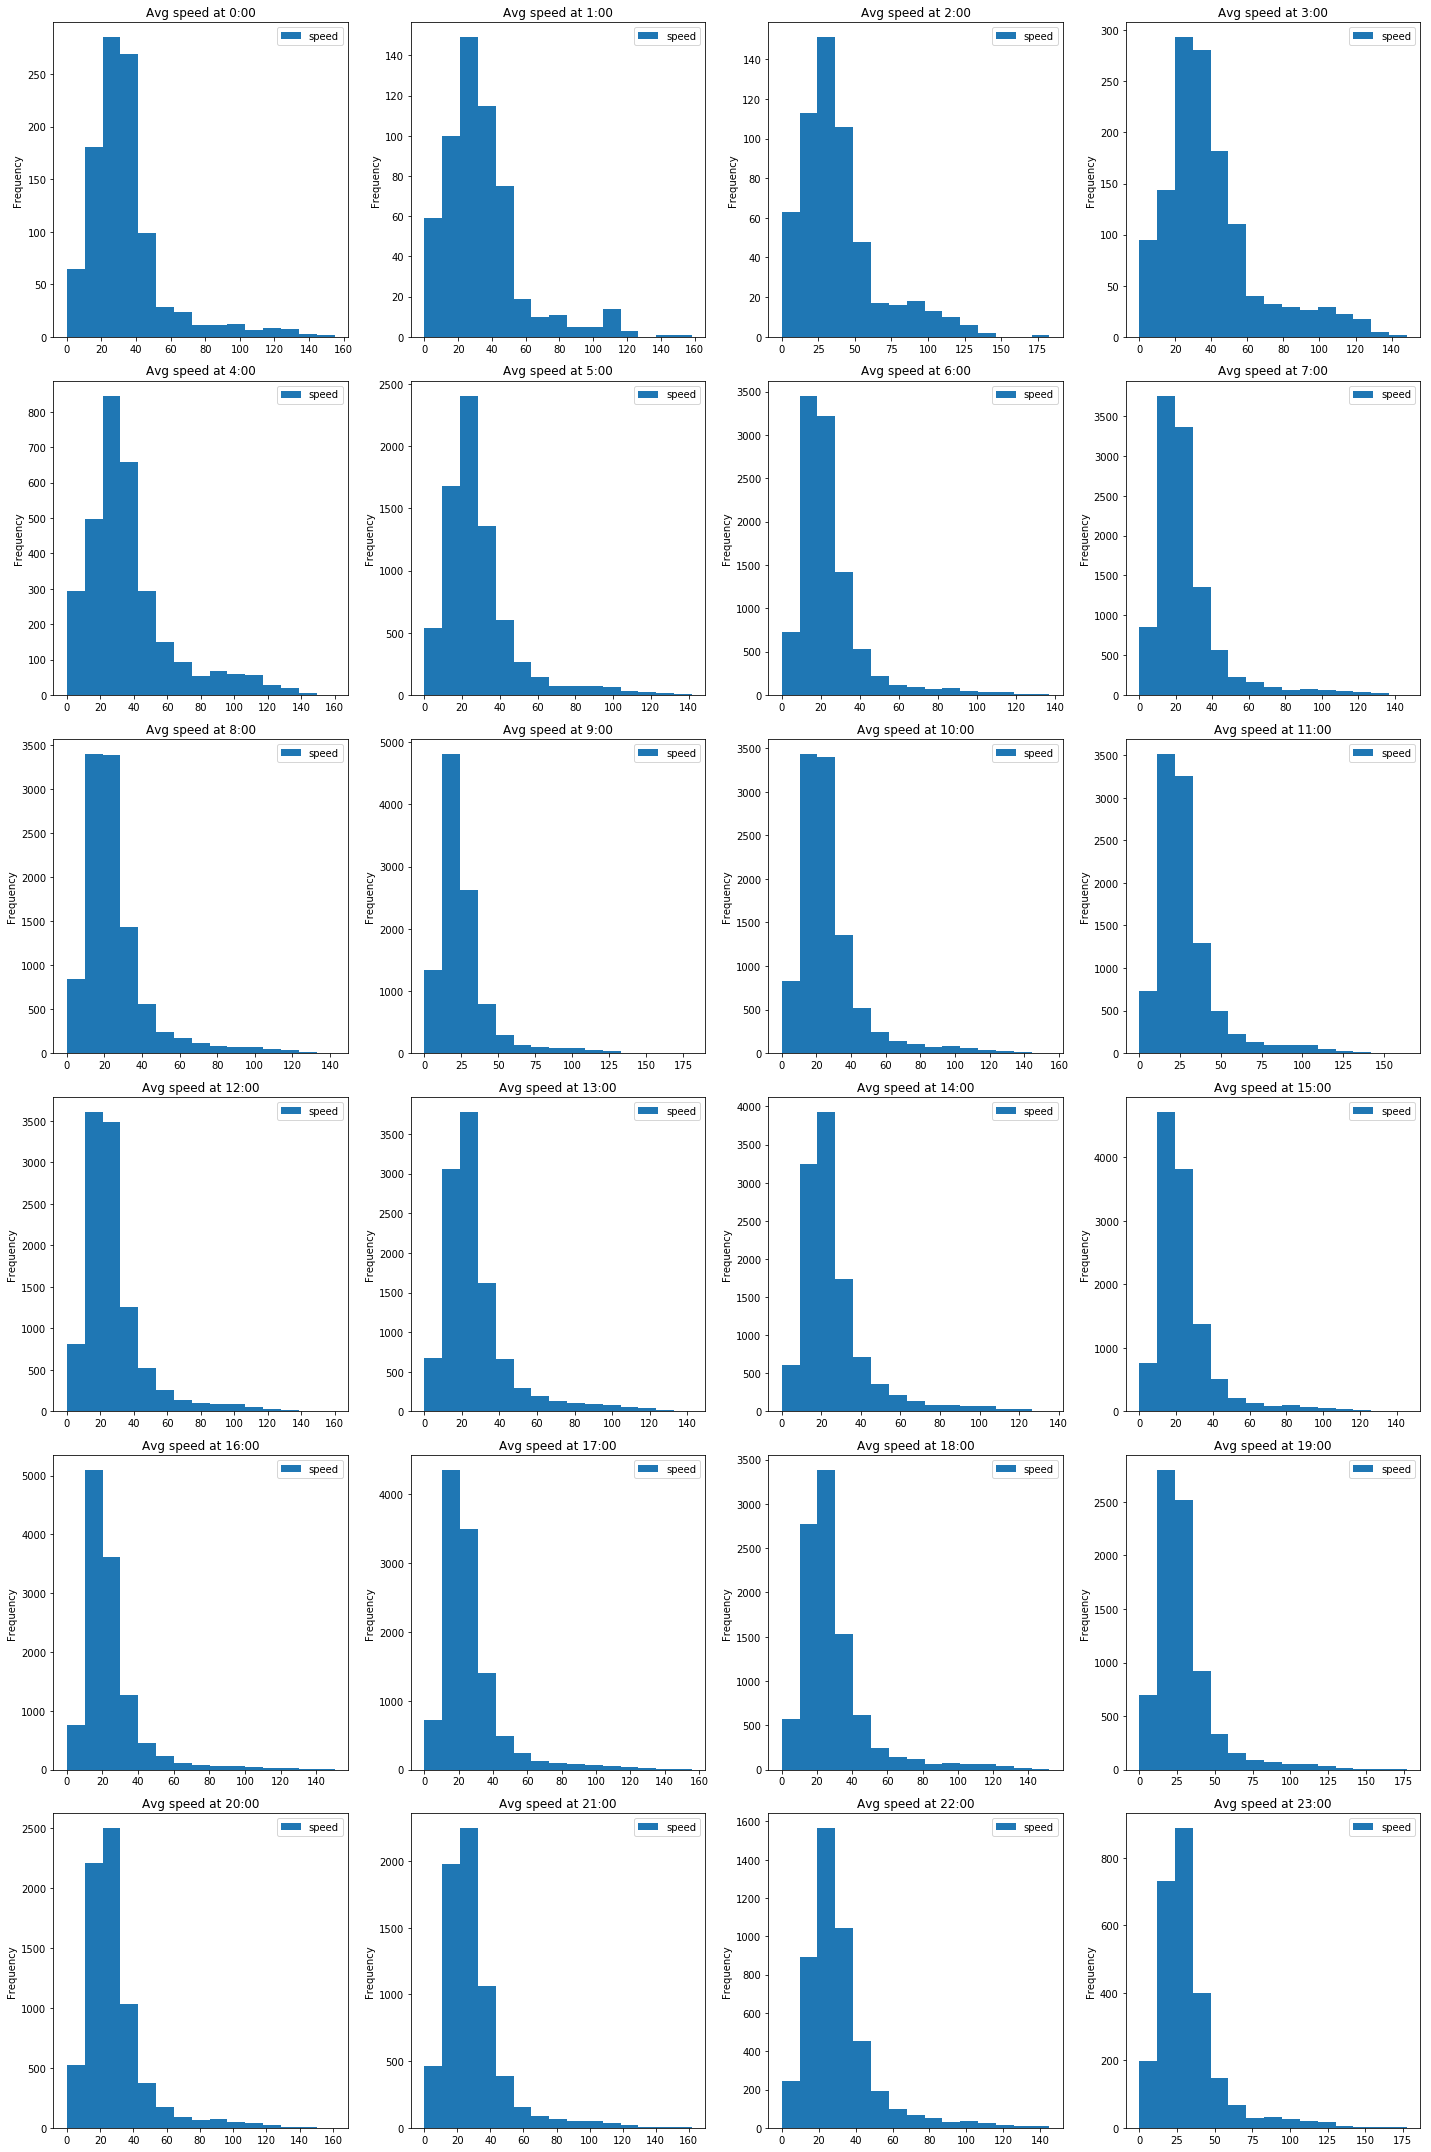

In [15]:
## Plot speed distributions by hour of the day, excluding weekends and festivities

medians2, avgs = avg_speed_dist(turin_june[(turin_june.engine_status == 1) &
                                          (~turin_june.day_of_the_week.isin([6, 7])) &
                                          (turin_june.day != date(2017, 6, 2))])

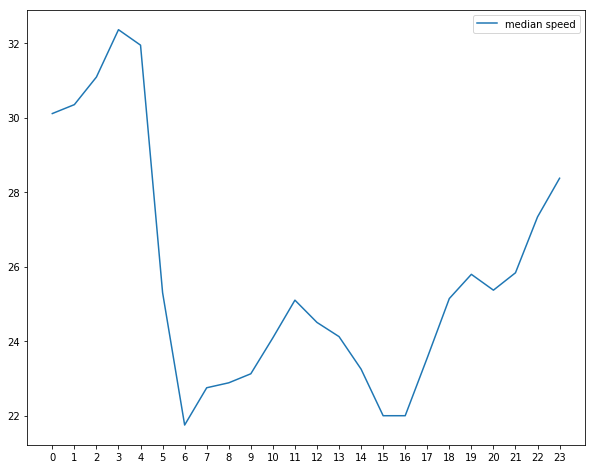

In [16]:
## Plot median distribution by hour of the day, weekends and festivity excluded

plt.figure(figsize=(10, 8))
plt.plot(range(0, 24), medians, label='median speed')
plt.xticks(range(0, 24))
plt.legend()

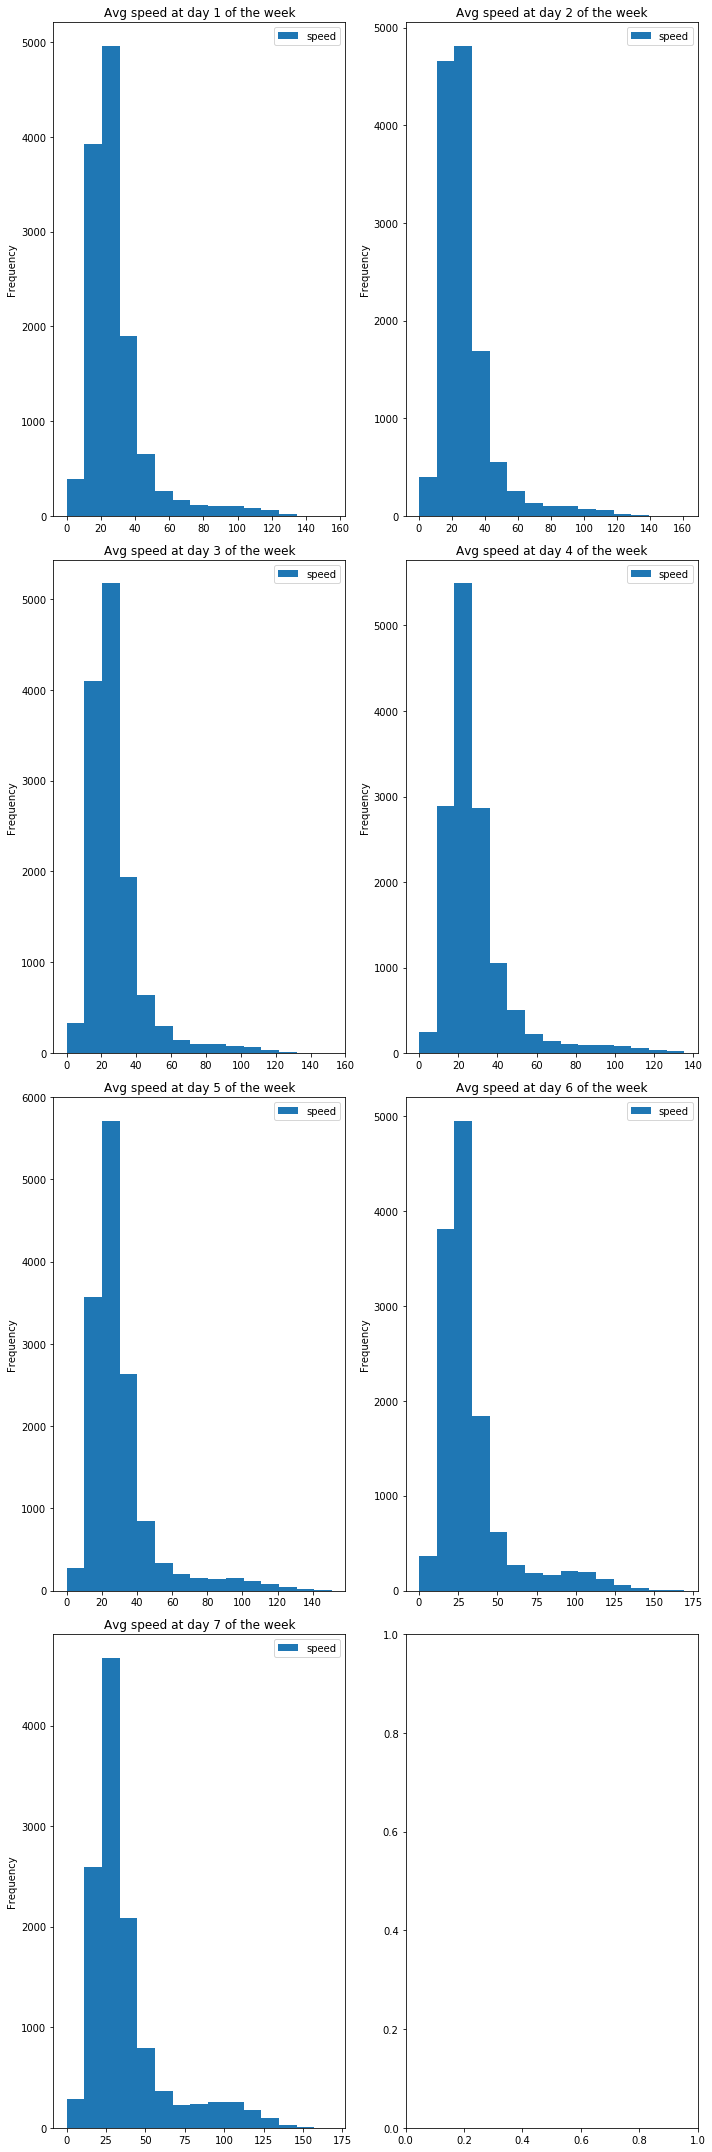

In [17]:
## Plot speed distributions by day of the week

medians_weekday, _ = avg_speed_dist(turin_june[turin_june.engine_status == 1], mode='weekday')

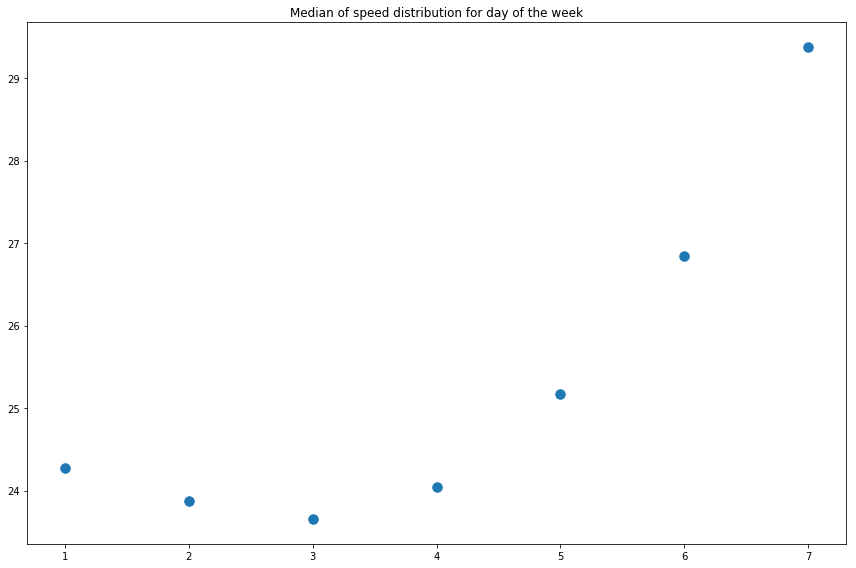

In [18]:
## Plot median speed values by day of the week, and save it under the figurepath specification
figurepath = 'scatter_med_speed_by_weekday.png'

figure(figsize=(12, 8))
plt.scatter(range(1, 8), medians_weekday, label='median speed', s=90)
plt.title('Median of speed distribution for day of the week')
plt.tight_layout()
plt.savefig(figurepath)

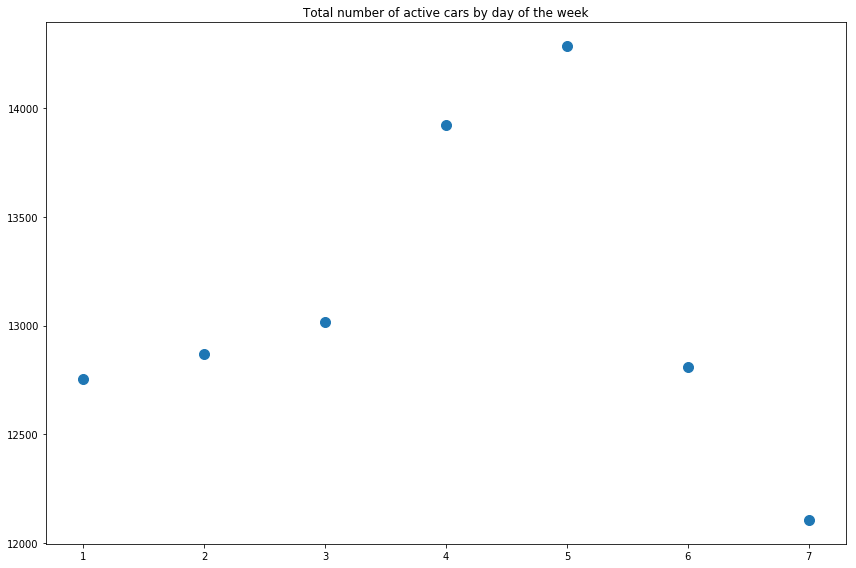

In [19]:
#Show number of active cars by day of the week and save it on the path given by figurepath
figurepath = 'active_cars_by_day.png'

figure(figsize=(12, 8))

# Compute the the number of active cars by grouping by day of the week, then save them in a list
num_of_cars = turin_june[(turin_june.engine_status == 1)].groupby('day_of_the_week').agg({'device_id': 'nunique'})\
.device_id.tolist()

plt.scatter(range(1, 8), num_of_cars, label='number of cars', s=100)
plt.title('Total number of active cars by day of the week')
plt.tight_layout()
plt.savefig(figurepath)

### Speed and cars number together
After seeing the graphs above, we first plot in the same figure the number of active cars and the median speed by hour of the day.  
Afterwards, we look for the existence of any (linear) correlation between the two.

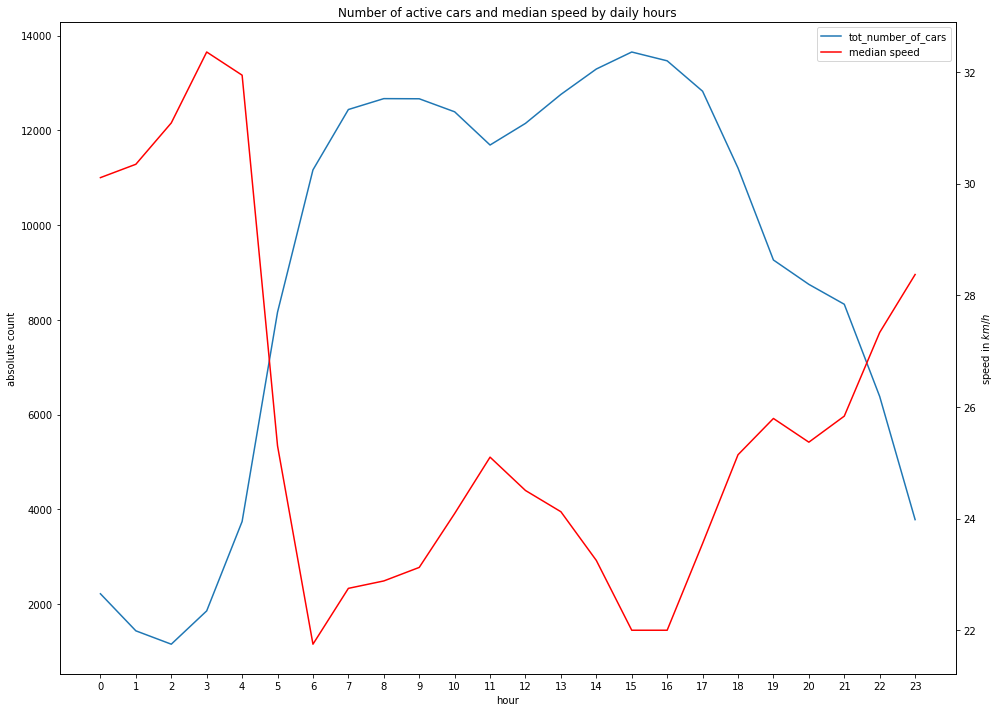

In [20]:
# Plots number of active cars and median speed, aggregated by hour. Saves the resulting graph under figurepath
figurepath = 'double_plot.png'

# create matplotlib figure and axis
fig, ax1 = plt.subplots()

# compute the number of active cars via aggregation by hour, then plot it using 
turin_june[(turin_june.engine_status == 1)].groupby('hour', as_index=False).agg({'device_id': 
                                                                                 'nunique'})\
.plot(kind='line', x='hour', y='device_id', figsize=(14, 10), label='tot_number_of_cars',
     ax=ax1)
ax1.set_xticks(range(24))
ax2 = ax1.twinx()          # generate a second matplotlib axis that shares the same x with first axis
                           # this is done to plot together y values with different orders of magnitude

ax2.plot(range(0, 24), medians, label='median speed', c='r')
ax1.set_ylabel('absolute count')
ax2.set_ylabel('speed in ' + '$km/h$')

# return the legends
ax1.legend()
ax2.legend()
# save the handles and labels inside the legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

# remove the legend from ax2 in order to show one unique legend, and not two distinct ones (1 for each axis)
ax2.legend_.remove()
ax1.legend(h1 + h2, l1 + l2)
plt.title('Number of active cars and median speed by daily hours')
plt.tight_layout()
plt.savefig(figurepath)

Pearson coefficient is -0.949 and its square is 0.900, while we have a p-value of 0.0000


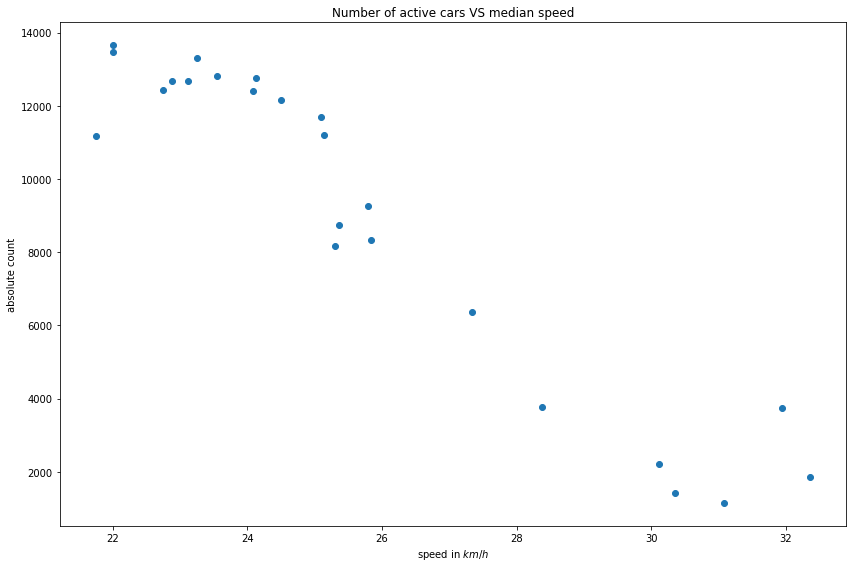

In [24]:
# Makes a scatter plot of number of distinct cars and median speed by hour. Computes linear correlation
# Save plot under figurepath

figurepath = 'ncars_&_speed_scatter_plot.png'

from scipy.stats import pearsonr  # import the function for computing pearson coefficient 

n_cars = turin_june[(turin_june.engine_status == 1)].groupby('hour', as_index=False)\
.agg({'device_id': 'nunique'}).device_id.tolist()

figure(figsize=(12, 8))
plt.scatter(medians, n_cars)

r, pv = pearsonr(medians, n_cars)
print('Pearson coefficient is %.3f and its square is %.3f, while we have a p-value of %.4f' % (r, r**2, pv))
plt.title('Number of active cars VS median speed')
plt.ylabel('absolute count')
plt.xlabel('speed in $km / h$')
plt.tight_layout()
plt.savefig(figurepath)

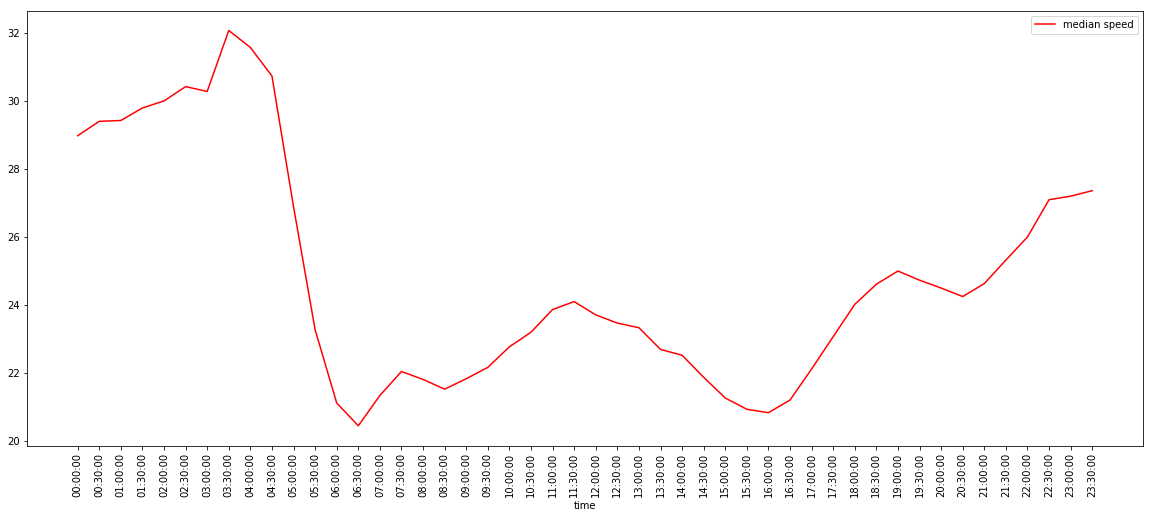

In [33]:
## Look at peaks and bottoms of speed with more time granularity (every half an hour)

medians_half, _ = avg_speed_dist(turin_june[turin_june.engine_status == 1], mode='hour_half', plotting=False)

fig = figure(figsize=(20, 8))
tick = sorted(turin_june.hour_half.unique())
plt.plot(tick, medians_half, label='median speed', c='r')
plt.xticks(tick, tick, rotation='vertical')
plt.legend();

```python
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(temp['lon'], temp['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()
```

# Building the grid

We decide to build the grid by simply flooring the latitude and longitude values in the dataset at a specific decimal point. We decide to floor the longitude to the nearest 0.005 multiple, and to floor the latitude to the nearest 0.0025 multiple. So for the longitude we want, for instance  
```python
special_floor(7.458) = 7.455
special_floor(7.461) = 7.460
```  
and for the latitude something like
```python
special_floor2(45.5564) = 45.5560
special_floor2(45.5566) = 45.5565
```  

In [34]:
def special_floor(n):
    return round(floor(n * 400)/400, 4)

def special_floor2(n):
    return round(floor(n * 200)/200, 3)

In [ ]:
# Map every position in the dataset to the corresponding cell in the grid.
# By the flooring approach, what we get from the mapping is the low-left angle of the rectangular cells

turin_june['grid_lon'] = turin_june.lon.apply(lambda l: special_floor2(l))
turin_june['grid_lat'] = turin_june.lat.apply(lambda l: special_floor(l))

In [212]:
turin_june['col_number'] = ((turin_june.grid_lon - turin_june.grid_lon.min()) * 200).round().astype(int)
turin_june['row_number'] = ((turin_june.grid_lat - turin_june.grid_lat.min()) * 400).round().astype(int)

tot_cols = turin_june.col_number.max()
turin_june['cell_number'] = (turin_june.row_number*tot_cols) + turin_june.col_number
turin_june['cell_centroid_lat'] = turin_june.grid_lat + 0.00125
turin_june['cell_centroid_lon'] = turin_june.grid_lon + 0.0025

In [8]:
agg_speed = turin_june[turin_june.engine_status == 
                       1].groupby(['day_of_the_week', 'hour_half', 
                                   'cell_number']).agg({'speed': np.mean, 'acceleration': np.size,
                                                       'device_id': 'nunique'})\
.rename(columns={'acceleration': 'n_records', 'device_id': 'n_cars'})

In [27]:
## Take distinct cars and the first speed in the half-an-hour time window

distinct_avg_speed = turin_june[turin_june.engine_status == 1]/
.drop_duplicates(subset=['day_of_the_week', 'hour_half', 'cell_number', 'device_id']).groupby(['day_of_the_week', 
                                                                                               'hour_half', 
                                                                                               'cell_number'])\
.agg({'speed': np.mean, 'device_id': 'nunique'})\
.rename(columns={'device_id': 'n_cars'}).reset_index()

distinct_avg_speed = distinct_avg_speed[distinct_avg_speed.speed > 0]
distinct_avg_speed['TL_c'] = distinct_avg_speed.n_cars / distinct_avg_speed.speed
distinct_tl = distinct_avg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_c': np.mean})

In [9]:
# Set a threshold to select meaningful rows

agg_speed = agg_speed[agg_speed.n_cars >= 10].reset_index()
tl_c = agg_speed.n_cars / agg_speed.speed
tl_r = agg_speed.n_records / agg_speed.speed
agg_speed['TL_r'] = tl_r
agg_speed['TL_c'] = tl_c

In [19]:
traffic_level = agg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_r': np.mean, 'TL_c': np.mean})

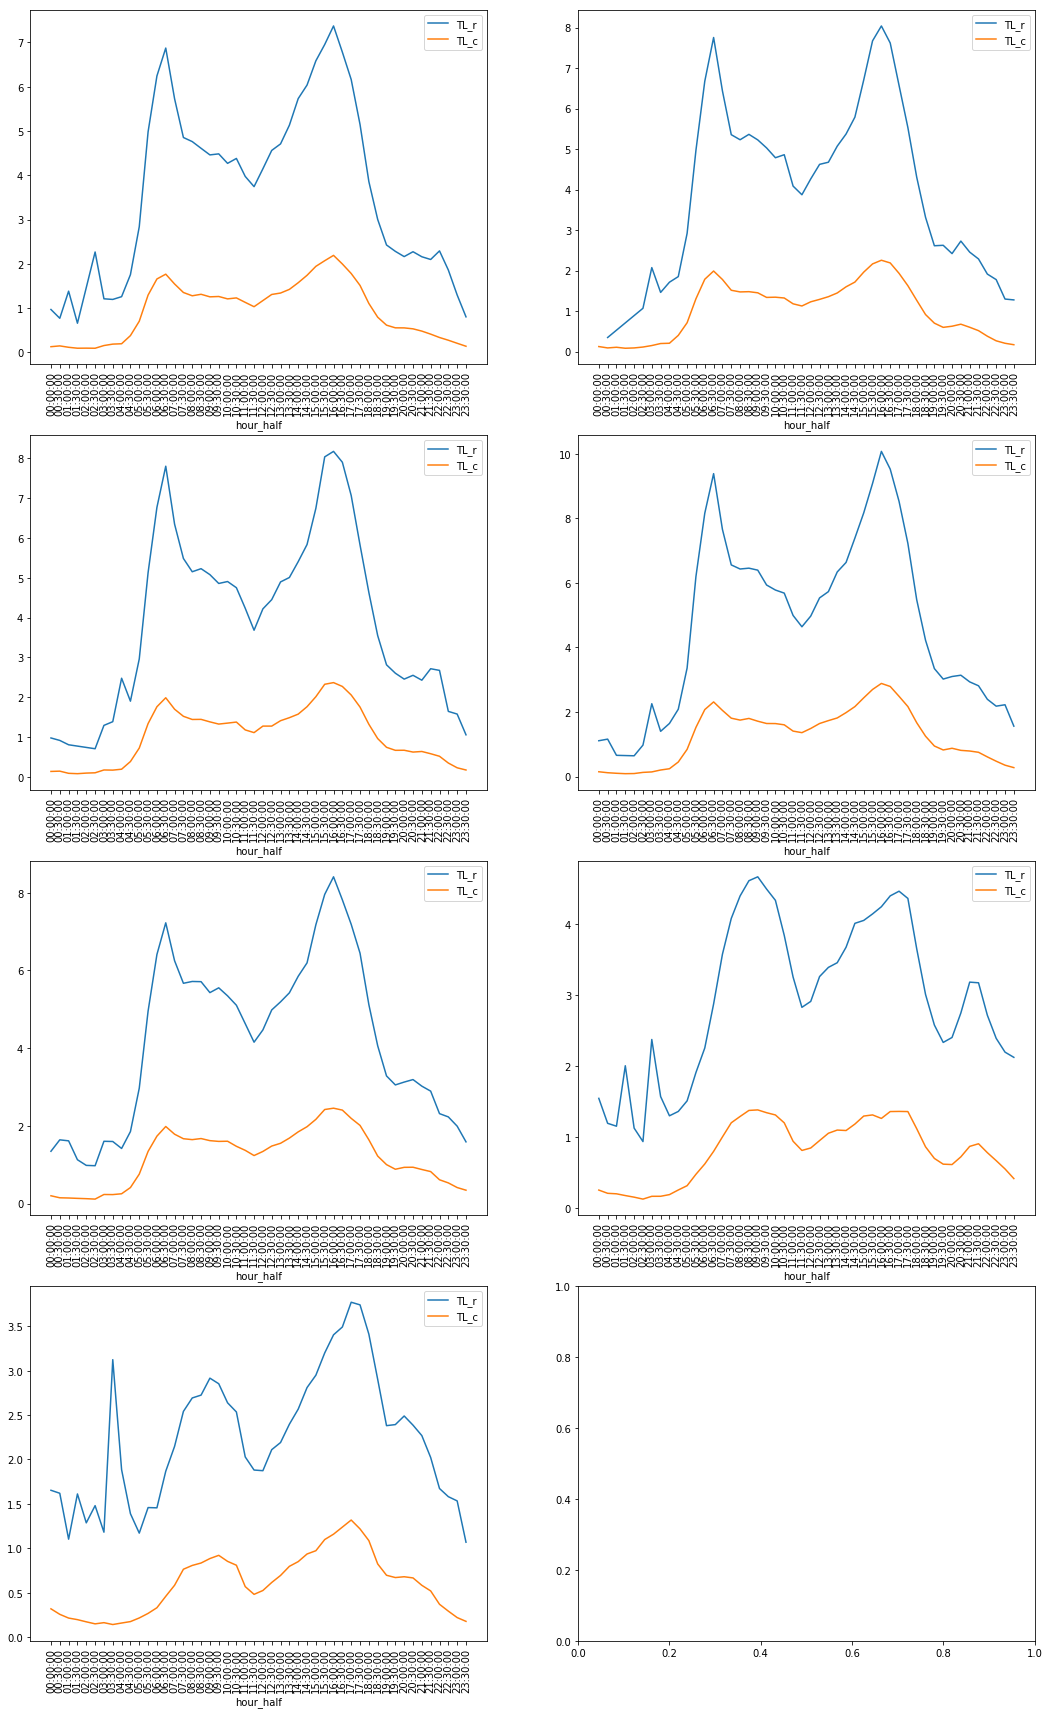

In [39]:
fig = plt.figure(figsize=(18, 30))
hours = sorted(traffic_level.hour_half.unique())
axes = fig.subplots(4, 2)
for d in range(1, 8):
    i = int((d-1)/2)
    j = (d-1)%2
    traffic_level[traffic_level.day_of_the_week == d].plot(x='hour_half', y='TL_r', ax=axes[i,j], label='TL_r', rot=90)
    #traffic_level[traffic_level.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i,j], label='TL_c', rot=90)
    distinct_tl[distinct_tl.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i, j], label='TL_c', rot=90)
    axes[i, j].set_xticks(hours)
    axes[i, j].legend()

In [377]:
import shapely
#import libHex
import imp 
import folium
import seaborn as sns

name_start_point = "origin_point"
name_end_point = "dest_point"
#7.6017, 45.0080, 7.7336, 45.1326.
max_lon = 7.7336
min_lon = 7.6017
max_lat = 45.1326
min_lat = 45.0080
listpoint =[[max_lat, min_lon], [max_lat, max_lon],[min_lat,max_lon], [min_lat,min_lon], [max_lat,min_lon]]
listpoint = [ [float(x[0]), float(x[1])] for x in listpoint]

circlepoints = []
lat = hd_coords[:, 0].min()
max_lat = hd_coords[:, 0].max()
while lat<=max_lat:
    lng = min_lon
    while lng<=max_lon:
        circlepoints.append([lat,lng])
        lng+=(max_lon-min_lon)/10.0
        lat+=(max_lat-min_lat)/10.0
            
lines = []
lat = hd_coords[:, 0].min() - 0.0025
while lat<=45.141:
    lines.append([[lat, 7.575], [lat, 7.77]])
    lat+=0.0025
    
lon = 7.575
while lon<=7.77:
    lines.append([[45.005, lon],[45.140, lon]])
    lon+=0.005
    
"""def point_on_right(locs):
    return [locs[0], round(locs[1] + 0.005, 4)]

def point_up(locs):
    return [round(locs[0] + 0.0025, 4), locs[1]]

for row in hd_coords:
    row = row.tolist()
    left_up = point_up(row)
    right_up = point_on_right(left_up)
    right_down = point_on_right(row)
    # left up line
    lines.append([row, left_up])
    # up right line
    lines.append([left_up, right_up])
    # down right line
    lines.append([row, right_down])
    # right up line
    lines.append([right_down, right_up])"""

map_folium =  folium.Map(location = [ (max_lat + min_lat)/2, (max_lon + min_lon)/2], zoom_start=11)

map_folium.add_child(folium.PolyLine(lines, weight=1.5))

#line = folium.PolyLine(listpoint)
#colors = np.array(sns.color_palette('Set2', 30))[groups].tolist()

"""for c, locs in enumerate(cent_coords):
    folium.CircleMarker(locs, radius=2).add_to(map_folium)
for c, locs in enumerate(strange_coords):
    folium.CircleMarker(locs, radius=2, color='#f53107').add_to(map_folium)"""
   
# map_folium.add_child(line)
#map_folium.add_child(point)
map_folium

In [323]:
path='my_map.html'
map_folium.create_map(path)

AttributeError: 'Map' object has no attribute 'create_map'

In [102]:
turin_june.col_number.max(), turin_june.row_number.max()

(39, 54)

In [170]:
## Valuate cell density

cell_density = turin_june[turin_june.engine_status == 1]\
.groupby(['cell_number', 'day'], as_index=False).agg({'device_id': 'nunique'})\
.groupby('cell_number', as_index=False).agg({'device_id': np.mean}).rename(columns={'device_id': 'car_density'})

In [120]:
cell_density[cell_density.car_density >= 175].car_density.describe()

count    514.000000
mean     303.689559
std      111.585733
min      175.933333
25%      217.516667
50%      272.950000
75%      361.725000
max      780.600000
Name: car_density, dtype: float64

In [171]:
# Get high density cell numbers and their coordinates

hd_cells = cell_density[cell_density.car_density >= 175].cell_number.unique()
print(len(hd_cells))

# Get rid of lonely cells

cell_list = hd_cells.tolist()
for c in hd_cells:
    neighs = [c - 1, c + 1, c - 40, c + 40, c - 39, c - 41, c + 41, c + 39]
    s = 0
    for n in neighs:
        s += (hd_cells == n).sum()
    if s == 0:
        cell_list.remove(c)
        
hd_coords = turin_june.loc[turin_june.cell_number.isin(cell_list), ['cell_number','grid_lat', 'grid_lon']]\
.drop_duplicates(subset=['cell_number']).drop('cell_number', 1).values
print(hd_coords.shape)
turin_june.row_number.max(), turin_june.col_number.max()

514
(500, 2)


(54, 39)

In [175]:
cent_coords = turin_june.loc[turin_june.cell_number.isin(cell_list), ['cell_number','cell_centroid_lat', 'cell_centroid_lon']]\
.drop_duplicates(subset=['cell_number']).drop('cell_number', 1).values

In [185]:
strange_coords = turin_june.loc[turin_june.cell_number.isin(strange_cells[:10]), ['cell_number','cell_centroid_lat', 'cell_centroid_lon']]\
.drop_duplicates(subset=['cell_number']).drop('cell_number', 1).values

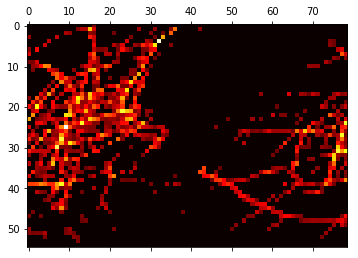

In [42]:
m = np.zeros((55, 79))
for i in range(55):
    for j in range(79):
        cell = i*79 + j
        if len(cell_density.loc[cell_density.cell_number == cell]) == 0:
            m[i, j] = 0
        else:
            if cell_density.loc[cell_density.cell_number == cell, 'car_density'].values[0] < 100:
                m[i, j] = 0
            else:
                m[i, j] = cell_density.loc[cell_density.cell_number == cell, 'car_density'].values[0]
        
plt.matshow(m, cmap='hot')

count    375.000000
mean      14.853263
std       15.237483
min        1.000000
25%        1.696679
50%        7.700000
75%       27.300000
max       49.566667
Name: device_id, dtype: float64

In [93]:
cell_density.device_id.describe

count    1070.000000
mean      172.691221
std       180.625760
min         1.000000
25%        23.966667
50%       106.800000
75%       270.558333
max       946.333333
Name: device_id, dtype: float64

In [98]:
## Selecting high density cells only. I guess we used the big grid 005 x 005

hd_cells = cell_density[cell_density.device_id >= 50].cell_number.values
ld_cells = cell_density[cell_density.device_id < 50].cell_number.values
len(hd_cells), len(ld_cells)

(695, 375)

In [439]:
distinct_avg_speed = turin_june[(turin_june.engine_status == 1) &
                               turin_june.cell_number.isin(hd_cells)].drop_duplicates(subset=['day_of_the_week', 'hour_half', 'cell_number', 
                                                 'device_id']).groupby(['day_of_the_week', 'hour_half', 
                                   'cell_number']).agg({'speed': np.mean, 'device_id': 'nunique'})\
.rename(columns={'device_id': 'n_cars'}).reset_index()

distinct_avg_speed = distinct_avg_speed[distinct_avg_speed.speed > 0]
distinct_avg_speed['TL_c'] = distinct_avg_speed.n_cars / distinct_avg_speed.speed
distinct_tl = distinct_avg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_c': np.mean})

In [460]:
hours = sorted(turin_june.hour_half.unique())
hours[::2] = ['.']*len(hours[::2])
hours

['.',
 '00:30:00',
 '.',
 '01:30:00',
 '.',
 '02:30:00',
 '.',
 '03:30:00',
 '.',
 '04:30:00',
 '.',
 '05:30:00',
 '.',
 '06:30:00',
 '.',
 '07:30:00',
 '.',
 '08:30:00',
 '.',
 '09:30:00',
 '.',
 '10:30:00',
 '.',
 '11:30:00',
 '.',
 '12:30:00',
 '.',
 '13:30:00',
 '.',
 '14:30:00',
 '.',
 '15:30:00',
 '.',
 '16:30:00',
 '.',
 '17:30:00',
 '.',
 '18:30:00',
 '.',
 '19:30:00',
 '.',
 '20:30:00',
 '.',
 '21:30:00',
 '.',
 '22:30:00',
 '.',
 '23:30:00']

0 0
0 1
0 2
0 3
1 0
1 1
1 2


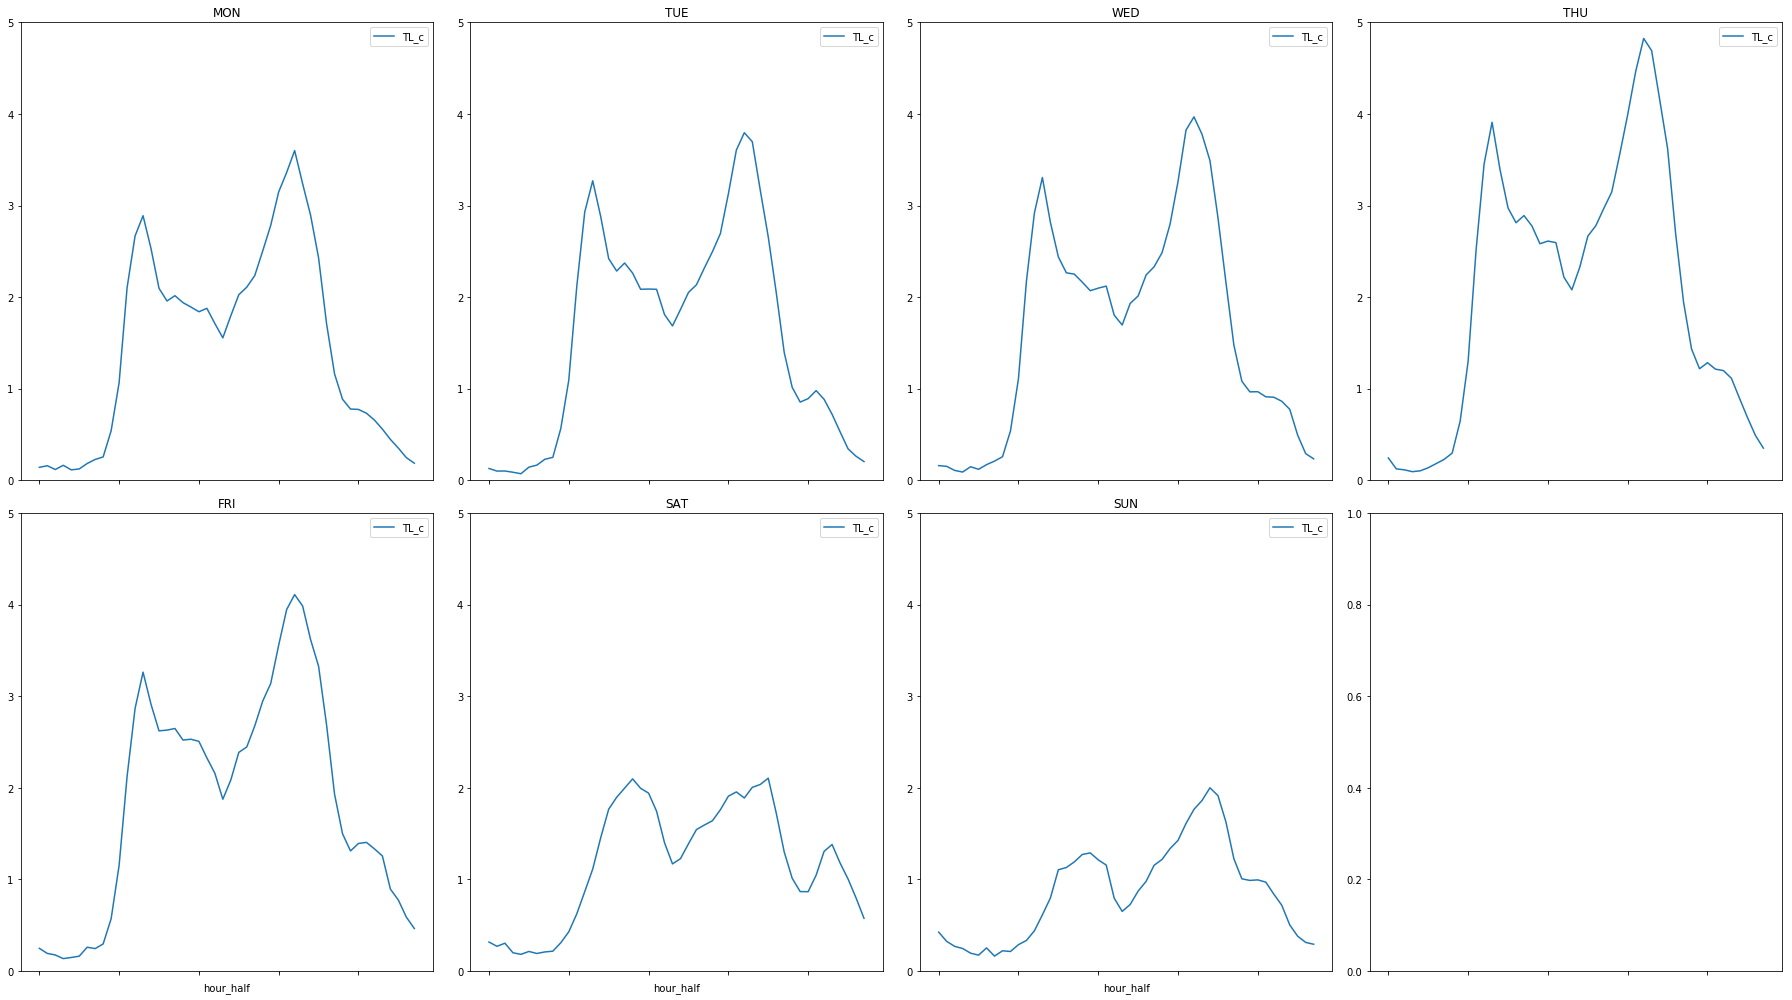

In [462]:
fig = plt.figure(figsize=(25, 14))

axes = fig.subplots(2, 4, sharex=True)
dadays = dict(zip(range(1, 8), ['MON','TUE', "WED", 'THU', 'FRI', 'SAT', 'SUN']))
for d in range(1, 8):
    i = int((d-1)/4)
    j = (d-1)%4
    print(i, j)
    distinct_tl[distinct_tl.day_of_the_week == d].plot(x='hour_half', y='TL_c', ax=axes[i, j], title=dadays[d], rot=90)
    #if (j!=3) & (i!= 1):
    
    #axes[i, j].legend()
    axes[i, j].set_ylim(0, 5)
    #axes[i, j].set_xticks(hours)
#plt.xticks(hours)
plt.tight_layout()
plt.savefig('tlllll.png')

### Sum it up

#### What we have learned so far
1. Number of distinct cars / avg speed inside a cell seems a good metric for measuring traffic levels
2. Traffic levels computed in this way seems stable during working days, then have some peculiar shape for saturday and sunday
3. To perform analysis, we chose only the cells with higher density

#### What we can try later
1. Change the grid shape (maybe finer)
2. Change time window
3. Decide aggregation in time window (now we just keep the first value for speed)

#### What we're gonna do now
1. Build the dataset with the feature vector: `weekday`, `hour_half`, `TL_30_min_before`, `TL_left`, `TL_up`, `TL_right`, `TL_down`. If the cell has not 4 neighbours, we set the TL feature values to an average value we compute

In [310]:
hours

NameError: name 'hours' is not defined

In [99]:
## Compute TL avg value for low density cells and insert the weekday-and-hour dependent values in a lookup_table

distinct_avg_speed = turin_june[(turin_june.engine_status == 1) &
                               turin_june.cell_number.isin(ld_cells)].drop_duplicates(subset=['day_of_the_week', 'hour_half', 'cell_number', 
                                                 'device_id']).groupby(['day_of_the_week', 'hour_half', 
                                   'cell_number']).agg({'speed': np.mean, 'device_id': 'nunique'})\
.rename(columns={'device_id': 'n_cars'}).reset_index()

distinct_avg_speed = distinct_avg_speed[distinct_avg_speed.speed > 0]
distinct_avg_speed['TL_c'] = distinct_avg_speed.n_cars / distinct_avg_speed.speed
distinct_tl = distinct_avg_speed.groupby(['day_of_the_week', 
                                   'hour_half'], as_index=False).agg({'TL_c': np.mean})

distinct_tl.describe()

,day_of_the_week,TL_c
count,336.000000,336.000000
mean,4.000000,0.156195
std,2.002983,0.063863
min,1.000000,0.022531
25%,2.000000,0.104884
50%,4.000000,0.161470
75%,6.000000,0.202111
max,7.000000,0.333897


In [313]:
# lookup_table = distinct_tl
hours = sorted(turin_june.hour_half.unique())
map_h_to_int = dict(zip(hours, range(1, 49)))
map_h_to_int

{'00:00:00': 1,
 '00:30:00': 2,
 '01:00:00': 3,
 '01:30:00': 4,
 '02:00:00': 5,
 '02:30:00': 6,
 '03:00:00': 7,
 '03:30:00': 8,
 '04:00:00': 9,
 '04:30:00': 10,
 '05:00:00': 11,
 '05:30:00': 12,
 '06:00:00': 13,
 '06:30:00': 14,
 '07:00:00': 15,
 '07:30:00': 16,
 '08:00:00': 17,
 '08:30:00': 18,
 '09:00:00': 19,
 '09:30:00': 20,
 '10:00:00': 21,
 '10:30:00': 22,
 '11:00:00': 23,
 '11:30:00': 24,
 '12:00:00': 25,
 '12:30:00': 26,
 '13:00:00': 27,
 '13:30:00': 28,
 '14:00:00': 29,
 '14:30:00': 30,
 '15:00:00': 31,
 '15:30:00': 32,
 '16:00:00': 33,
 '16:30:00': 34,
 '17:00:00': 35,
 '17:30:00': 36,
 '18:00:00': 37,
 '18:30:00': 38,
 '19:00:00': 39,
 '19:30:00': 40,
 '20:00:00': 41,
 '20:30:00': 42,
 '21:00:00': 43,
 '21:30:00': 44,
 '22:00:00': 45,
 '22:30:00': 46,
 '23:00:00': 47,
 '23:30:00': 48}

In [168]:
## Build the feature vectors
hours = sorted(turin_june.hour_half.unique())

map_h_to_int = dict(zip(hours, range(1, 49)))
map_d_to_int = dict(zip(range(1,8), ['W']*5 + ['ST', 'SN']))
little_turin = turin_june[(turin_june.engine_status == 1) &
                         (turin_june.cell_number.isin(cell_list))].copy()

# Transform weekday and hour
little_turin['day_of_the_week'] = little_turin.day_of_the_week.map(map_d_to_int)
little_turin['hour_half'] = little_turin.hour_half.map(map_h_to_int)

# Compute tl for each weekday, hour and cell

dataset = little_turin\
.groupby(['day_of_the_week', 'hour_half', 'cell_number', 'device_id'], as_index=False).agg({'speed': np.mean})\
.groupby(['day_of_the_week', 'hour_half', 'cell_number'], as_index=False).agg({'device_id': 'nunique', 
                                                                               'speed': np.mean})\
.rename(columns={'device_id': 'n_cars'})
dataset.speed.describe()

count    71630.000000
mean        34.940236
std         24.098019
min          0.000000
25%         19.786194
50%         26.152265
75%         39.166667
max        180.000000
Name: speed, dtype: float64

In [170]:
dataset_10 = dataset.loc[(dataset.hour_half == 10)]
bad_speed_10 = dataset_10[dataset_10.speed == 0]

In [171]:
# Select only hours after very early morning (5 AM - 11.30 PM)

dataset = dataset.loc[dataset.hour_half.between(11, 47)]

bad_speed_values = dataset[dataset.speed == 0].index

In [172]:
dataset.loc[dataset.speed != 0, 'TL'] = 1. / dataset.speed
dataset_10.loc[dataset_10.speed != 0, 'TL'] = 1. / dataset_10.speed

In [173]:
# clean row with speed == 0

for c, h in dataset.loc[dataset.speed == 0, ['cell_number', 'hour_half']].values.tolist():
    print(c, h)
    neighs = [c - 1, c + 1, c - 40, c + 40, c - 39, c - 41, c + 41, c + 39]
    d = dataset[dataset.cell_number.isin(neighs)]
    if not len(d):
        print('no neigs for cell %d for hour %d' %(c, h))
    else:
        dataset.loc[(dataset.speed == 0) & (dataset.cell_number == c) & (dataset.hour_half == h),
                   'TL'] = d.TL.mean()
        
for c, h in dataset_10.loc[dataset_10.speed == 0, ['cell_number', 'hour_half']].values.tolist():
    print(c, h)
    neighs = [c - 1, c + 1, c - 40, c + 40, c - 39, c - 41, c + 41, c + 39]
    d = dataset_10[dataset_10.cell_number.isin(neighs)]
    if not len(d):
        print('no neigs for cell %d for hour %d' %(c, h))
    else:
        dataset_10.loc[(dataset_10.speed == 0) & (dataset_10.cell_number == c) & (dataset_10.hour_half == h),
                   'TL'] = d.TL.mean()

562 11
1454 11
1467 11
1415 12
606 13
876 13
707 46
597 10
792 10
1111 10
1179 10
1495 10


In [228]:
dataset

,day_of_the_week,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,TL
0,SN,11,45.00875,7.6125,0.015026,0.008326,46,17,110.029412,0.009088
1,SN,11,45.00875,7.6175,0.016936,0.012444,47,21,62.968254,0.015881
2,SN,11,45.00875,7.6225,0.015026,0.024874,48,11,40.590909,0.024636
3,SN,11,45.00875,7.6725,0.012567,0.015306,58,10,73.600000,0.013587
4,SN,11,45.01125,7.6225,0.018920,0.017608,87,5,42.000000,0.023810
5,SN,11,45.01125,7.6725,0.015306,0.012567,97,4,71.000000,0.014085
6,SN,11,45.01375,7.6025,0.008183,0.008859,122,6,128.833333,0.007762
7,SN,11,45.01375,7.6225,0.024107,0.022642,126,4,26.000000,0.038462
8,SN,11,45.01375,7.6275,0.022882,0.026316,127,7,43.071429,0.023217
9,SN,11,45.01375,7.6675,0.023466,0.011396,135,9,44.703704,0.022370


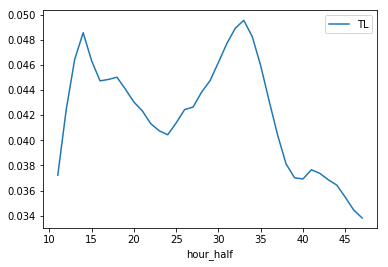

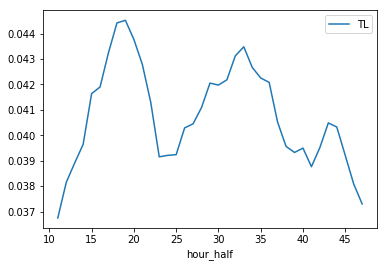

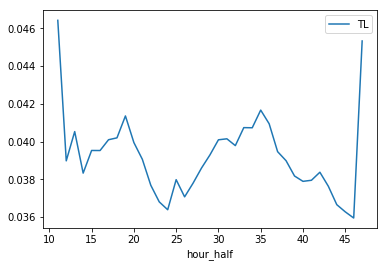

In [150]:
for d in ['W', 'ST', 'SN']:
    dataset[dataset.day_of_the_week == d].groupby(['hour_half'], as_index=False).agg({'TL': np.mean})\
    .plot(x='hour_half', y='TL')

In [379]:
def find_neighbours(c):
    return [c - 1, c + 1, c - 40, c + 40, c - 39, c - 41, c + 41, c + 39]

def previous_hours(h, c, df, day):
    if h == 11:
        df = dataset_10
    prev_h = h - 1
    if not len(df[(df.cell_number == c) & (df.hour_half == prev_h) & (df.day_of_the_week == day)]):
        n = find_neighbours(c)
        if not len(df[df.cell_number.isin(n) & (df.hour_half == prev_h) & (df.day_of_the_week == day)]):
            print('Cell %d han no neighs for hour %d!' %(c, h))
            return
            # if
        #else:
            #return df[df.cell_number.isin(n) & (df.hour_half == prev_h) & (df.day_of_the_week == day)].TL.mean()
    #else:
       # return df[(df.cell_number == c) & (df.hour_half == prev_h) & (df.day_of_the_week == day)].TL.values[0]

In [177]:
len(dataset)

55485

In [178]:
r = 0
h = 11
for d in ['SN']:
    #for h in range(11, 48):
    for c in dataset.cell_number.unique():
        print(d, h, c)
        res = previous_hours(h, c, dataset, d)
        if res is None:
            r += 1
print(r)

SN 11 46
SN 11 47
SN 11 48
SN 11 58
SN 11 87
SN 11 97
SN 11 122
SN 11 126
SN 11 127
SN 11 135
SN 11 161
SN 11 166
SN 11 170
SN 11 173
SN 11 174
SN 11 200
SN 11 206
SN 11 208
SN 11 209
SN 11 211
SN 11 212
SN 11 213
SN 11 238
SN 11 245
SN 11 246
SN 11 249
SN 11 252
SN 11 253
SN 11 275
SN 11 276
SN 11 277
SN 11 284
SN 11 285
SN 11 286
SN 11 287
SN 11 288
SN 11 292
SN 11 315
SN 11 316
SN 11 324
SN 11 330
SN 11 331
SN 11 354
SN 11 356
SN 11 357
SN 11 363
SN 11 364
SN 11 370
SN 11 396
SN 11 397
SN 11 398
SN 11 402
SN 11 403
SN 11 404
SN 11 405
SN 11 409
SN 11 410
SN 11 437
SN 11 438
SN 11 442
SN 11 443
SN 11 449
SN 11 477
SN 11 478
SN 11 480
SN 11 481
SN 11 482
SN 11 483
SN 11 487
SN 11 488
SN 11 489
SN 11 517
SN 11 518
SN 11 519
SN 11 521
SN 11 522
SN 11 527
SN 11 528
SN 11 557
SN 11 558
SN 11 559
SN 11 560
SN 11 561
SN 11 562
SN 11 565
SN 11 566
SN 11 567
SN 11 596
SN 11 597
SN 11 598
SN 11 599
SN 11 601
SN 11 603
SN 11 604
SN 11 605
SN 11 606
SN 11 607
SN 11 635
SN 11 637
SN 11 638
SN 11 

In [191]:
def tl_previous_half(tup):
    d = tup[0]
    h = tup[1]
    c = tup[2]
    if h == 11:
        df = dataset_10
    else:
        df = dataset
    prev_h = h - 1
    if not len(df[(df.cell_number == c) & (df.hour_half == prev_h) & (df.day_of_the_week == d)]):
        n = find_neighbours(c)
        return df[df.cell_number.isin(n) & (df.hour_half == prev_h) & (df.day_of_the_week == d)].TL.mean()
    else:
        return df[(df.cell_number == c) & (df.hour_half == prev_h) & (df.day_of_the_week == d)].TL.values[0]
    
def tl_neighs(tup, main_df, df_10):
    d = tup[0]
    h = tup[1]
    c = tup[2]
    if h == 11:
        df = dataset_10
    else:
        df = main_df
    h = h - 1
    n = find_neighbours(c)
    print('Did')
    return df[df.cell_number.isin(n) & (df.hour_half == h) & (df.day_of_the_week == d)].TL.mean()

In [189]:
dataset['tl_neighs'] = dataset.iloc[:, [0, 1, 2]].apply(tl_neighs, args=(dataset, dataset_10), axis=1)

Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did
Did


In [192]:
dataset['tl_prev_half'] = dataset.iloc[:, [0, 1, 2]].apply(tl_previous_half, axis=1)

In [224]:
dataset = dataset.merge(turin_june.drop_duplicates(subset=['cell_number'])[['cell_number',
                                                                 'cell_centroid_lat', 'cell_centroid_lon']], how='left',
             on=['cell_number'])

dataset = dataset.iloc[:, [0, 1, 8, 9, 6, 7, 2, 3, 4, 5]]

In [118]:
## Model evaluation

from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from xgboost.sklearn import XGBRegressor

In [242]:
dataset = pd.get_dummies(dataset)
dataset = dataset.iloc[:, [-3, -2, -1] + list(range(9))]
dataset

,day_of_the_week_SN,day_of_the_week_ST,day_of_the_week_W,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,TL
0,1,0,0,11,45.00875,7.6125,0.015026,0.008326,46,17,110.029412,0.009088
1,1,0,0,11,45.00875,7.6175,0.016936,0.012444,47,21,62.968254,0.015881
2,1,0,0,11,45.00875,7.6225,0.015026,0.024874,48,11,40.590909,0.024636
3,1,0,0,11,45.00875,7.6725,0.012567,0.015306,58,10,73.600000,0.013587
4,1,0,0,11,45.01125,7.6225,0.018920,0.017608,87,5,42.000000,0.023810
5,1,0,0,11,45.01125,7.6725,0.015306,0.012567,97,4,71.000000,0.014085
6,1,0,0,11,45.01375,7.6025,0.008183,0.008859,122,6,128.833333,0.007762
7,1,0,0,11,45.01375,7.6225,0.024107,0.022642,126,4,26.000000,0.038462
8,1,0,0,11,45.01375,7.6275,0.022882,0.026316,127,7,43.071429,0.023217
9,1,0,0,11,45.01375,7.6675,0.023466,0.011396,135,9,44.703704,0.022370


In [93]:
dataset[['tl_neighs', 'tl_prev_half']].describe()

,tl_neighs,tl_prev_half
count,55485.000000,55485.000000
mean,0.040900,0.040749
std,0.016353,0.024964
min,0.007812,0.007246
25%,0.032713,0.027931
50%,0.043004,0.040468
75%,0.050528,0.052149
max,0.527378,2.000000


54191


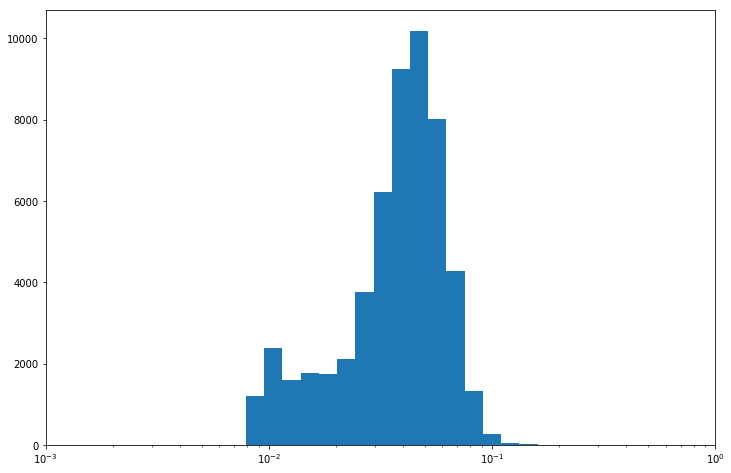

In [465]:
dataset.TL.hist(bins=np.logspace(-3, 1, 50),grid=False, figsize=(12, 8))
plt.xlim(1e-3,1e0)
plt.xscale('log')
print(len(dataset))
perc90 = dataset.TL.quantile(0.9999)
len(dataset[dataset.TL > perc90]), perc90
plt.savefig('tlnorm.png')

In [366]:
X, y = dataset.iloc[:, :8].values, dataset.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
scaler = MinMaxScaler()
X_trans = scaler.fit_transform(X_train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13ef96518>,
      dtype=object)

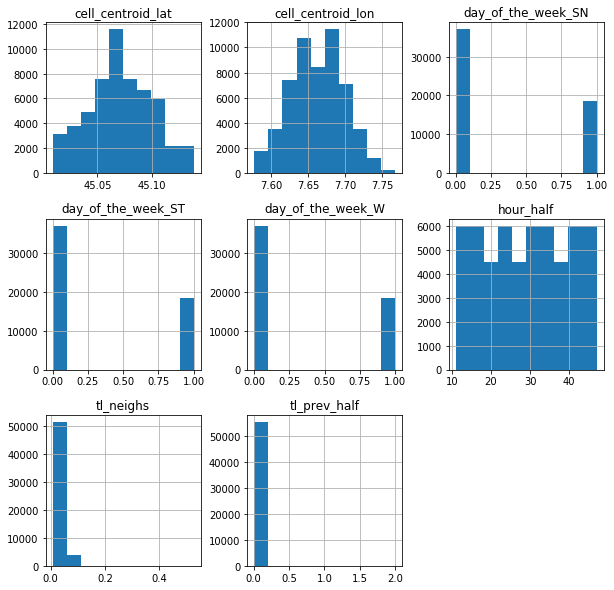

In [266]:
dataset.iloc[:, :8].hist(figsize=(10, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14a413fd0>,
      dtype=object)

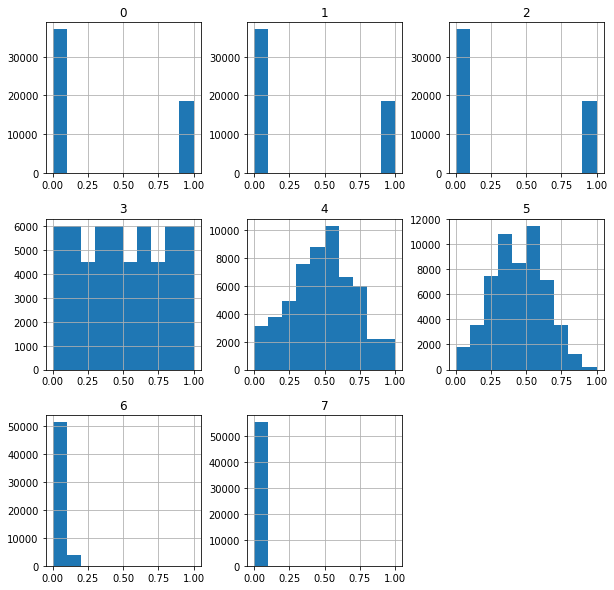

In [367]:
pd.DataFrame(MinMaxScaler().fit_transform(dataset.iloc[:, :8].values)).hist(figsize=(10, 10))

In [240]:
# forest = RandomForestRegressor(100, n_jobs=-1)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('TL_data.csv')
X, y = dataset.loc[dataset.n_cars > 6, dataset.columns[:8]].values, np.log(dataset.loc[dataset.n_cars > 6, 
                                                                                       'TL'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
scaler = MinMaxScaler()
scaler.fit(X_train)

X_trans = scaler.transform(X_train)

"""extree = ExtraTreesRegressor(100, n_jobs=-1)
boost = GradientBoostingRegressor()
xboost = XGBRegressor(n_jobs=-1)

models = [extree, boost, xboost]"""

'extree = ExtraTreesRegressor(100, n_jobs=-1)\nboost = GradientBoostingRegressor()\nxboost = XGBRegressor(n_jobs=-1)\n\nmodels = [extree, boost, xboost]'

In [202]:
folds = 10

scores = np.zeros((len(models), folds))
for i, m in enumerate(models):
    scores[i, :] = cross_val_score(m, X_trans, y_train, cv=folds, scoring='r2', n_jobs=-1, verbose=2)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  19.8s
[CV] ................................................. , total=  19.9s
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  20.1s
[CV]  ................................................................
[CV] ................................................. , total=  20.3s
[CV]  ................................................................
[CV] ................................................. , total=  17.3s
[CV] ................................................. , total=  17.3s
[CV]  

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   45.5s finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV] ................................................. , total=   4.6s
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................
[CV] ................................................. , total=   5.6s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.9s finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.7s
[CV]  ................................................................
[CV] ................................................. , total=   3.6s
[CV]  ................................................................
[CV] ................................................. , total=   3.8s
[CV]  ................................................................
[CV] ................................................. , total=   3.4s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.9s finished


In [282]:
print(scores.mean(axis=1))

[0.91500676 0.90229569 0.9022736 ]


In [201]:
for m in models:
    m.fit(X_trans, y_train)
    print(r2_score(y_test, m.predict(scaler.transform(X_test))))

0.9172046766466174
0.9037755091844866
0.9036036689536163


In [226]:
params = {'n_estimators': np.arange(100, 1100, 100), 'max_features': np.arange(2, 7), 'min_samples_split': 
          np.arange(2, 11), 'min_samples_leaf': np.arange(1, 10)}

In [227]:
from sklearn.model_selection import RandomizedSearchCV

In [228]:
# Check the performance of naive model
extree2 = ExtraTreesRegressor(100, n_jobs=-1)
rsearch = RandomizedSearchCV(extree2, params, n_iter=300, cv=5, verbose=2, n_jobs=-1, scoring='r2')

In [229]:
X_trans[X_trans == np.inf]

array([], dtype=float64)

In [230]:
rsearch.fit(X_trans, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3, total=  16.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3, total=  17.0s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_features=2 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3, total=  17.2s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=5, max_features=2 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=2, max_features=3, total=  

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min


[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=8, max_features=6, total=  25.4s
[CV] n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=8, max_features=6, total=  25.6s
[CV] n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5 
[CV]  n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5, total=  24.0s
[CV] n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5 
[CV]  n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5, total=  24.5s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=6 
[CV]  n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5, total=  24.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=6 
[CV]  n_estimators=500, min_samples_split=7, min_samples_leaf=5, max_features=5, total=  23.4s
[CV] n_estimators=1000, mi

[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6, total=  26.7s
[CV] n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6, total=  26.2s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4 
[CV]  n_estimators=1000, min_samples_split=8, min_samples_leaf=5, max_features=6, total=  58.1s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6, total=  25.1s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4 
[CV]  n_estimators=500, min_samples_split=10, min_samples_leaf=7, max_features=6, total=  26.0s
[CV] n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4 
[CV]  n_estimators=800, min_samples_split=4, min_samples_leaf=6, max_features=4, total=  27.9s
[CV] n_estimators=800, m

[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.2s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.9s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.8s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.8s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=5, max_features=3, total=   2.7s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=9, max_features=5 
[CV]  n_estimators=800, min_samples_split=7, min_samples_leaf=4, max_features=4, total=  33.9s
[CV] n_estimators=400, min_sam

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.5min


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=4, max_features=6, total=  58.7s
[CV] n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total=  58.3s
[CV] n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total= 1.0min
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=3, max_features=5 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total= 1.1min
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=3, max_features=5 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total= 1.1min
[CV] n_estimators=800, min_samples_split=7, min_samples_leaf=3, max_features=5 
[CV]  n_estimators=1000, min_samples_split=3, min_samples_leaf=5, max_features=6, total= 1.3min
[CV] n_estimators=800,

KeyboardInterrupt: 

In [307]:
rsearch.best_score_

0.6110317054738217

In [308]:
rsearch.best_params_

{'learning_rate': 0.0727895384398315, 'max_depth': 9, 'min_child_weight': 6}

In [321]:
final_xboost = XGBRegressor(**rsearch.best_params_, n_jobs=-1)
final_xboost.fit(X_trans, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.0727895384398315,
       max_delta_step=0, max_depth=9, min_child_weight=6, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [323]:
y_pred = final_xboost.predict(X_trans)
r2_score(y_train, y_pred), r2_score(X_train[:, 7], y_train)

(0.7554745345010462, 0.28279040668552835)

In [400]:
class BaseModel():
    def __init__(self):
        return

    def fit(self, X, y):
        return self
    
    def predict(self, X, y):
        return X[:, 7]
    
r2_score(X_train[:, 7], np.power(np.e, y_train))

0.534867434267164

In [332]:
X_trans_all = scaler.transform(X)

In [340]:
scaler.fit(X)
y_pred = final_xboost.predict(scaler.transform(X_test))
r2_score(y_test, y_pred)

0.1238560957573468

In [ ]:
## Check how much the model failes

map_h_to_int = dict(zip(hours, range(1, 49)))
everyday_cells = turin_june[(turin_june.cell_number.isin(cell_list)) & 
                            (turin_june.hour_half.map(map_h_to_int).between(11, 47))].copy()

everyday_cells = everyday_cells.groupby(['day', 'day_of_the_week', 'hour_half', 'cell_number', 
                                                      'device_id'], as_index=False).speed.mean()\
.groupby(['day', 'day_of_the_week', 'hour_half', 'cell_number'], as_index=False).agg({'device_id': 'nunique'})

#everyday_cells = everyday_cells.loc[(everyday_cells.speed > 0) & (everyday_cells.)]

In [106]:
dataset = pd.read_csv('TL_data.csv')
X, y = dataset.loc[dataset.n_cars > 6, dataset.columns[:8]].values, dataset.loc[dataset.n_cars > 6, 'TL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
scaler = MinMaxScaler()
scaler.fit(X_train)

X_trans = scaler.transform(X_train)

In [107]:
from  keras.models  import Sequential, model_from_json
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

In [275]:
checkpoint = ModelCheckpoint('random_try5.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [276]:
def mymet(y_true, y_pred):
    return r2_score(np.array(y_true), np.array(y_pred))

HIDDEN1 = 25
HIDDEN2 = 50
n_epochs = 20
model = Sequential()
model.add(Dense(HIDDEN1, input_shape=(8, ), activation='relu'))
model.add(Dense(HIDDEN2, activation='relu'))
# model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, ))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 25)                225       
_________________________________________________________________
dense_89 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_90 (Dense)             (None, 5)                 255       
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 6         
Total params: 1,786
Trainable params: 1,786
Non-trainable params: 0
_________________________________________________________________


In [277]:
hist1 = model.fit(X_trans, y_train,
          validation_split=0.2,
          epochs=100, batch_size=128, callbacks=callbacks_list, verbose=1)

Train on 34681 samples, validate on 8671 samples
Epoch 1/100
34681/34681 [==============================] - 2s 44us/step - loss: 4.6616 - val_loss: 0.3216

Epoch 00001: val_loss improved from inf to 0.32159, saving model to random_try5.hdf5
Epoch 2/100
34681/34681 [==============================] - 1s 17us/step - loss: 0.2406 - val_loss: 0.1724

Epoch 00002: val_loss improved from 0.32159 to 0.17240, saving model to random_try5.hdf5
Epoch 3/100
34681/34681 [==============================] - 1s 17us/step - loss: 0.1486 - val_loss: 0.1290

Epoch 00003: val_loss improved from 0.17240 to 0.12901, saving model to random_try5.hdf5
Epoch 4/100
34681/34681 [==============================] - 1s 35us/step - loss: 0.1137 - val_loss: 0.0969

Epoch 00004: val_loss improved from 0.12901 to 0.09692, saving model to random_try5.hdf5
Epoch 5/100
34681/34681 [==============================] - 1s 31us/step - loss: 0.0906 - val_loss: 0.0820

Epoch 00005: val_loss improved from 0.09692 to 0.08195, saving m

34681/34681 [==============================] - 1s 18us/step - loss: 0.0300 - val_loss: 0.0299

Epoch 00094: val_loss did not improve from 0.02918
Epoch 95/100
34681/34681 [==============================] - 1s 17us/step - loss: 0.0300 - val_loss: 0.0299

Epoch 00095: val_loss did not improve from 0.02918
Epoch 96/100
34681/34681 [==============================] - 1s 18us/step - loss: 0.0296 - val_loss: 0.0295

Epoch 00096: val_loss did not improve from 0.02918
Epoch 97/100
34681/34681 [==============================] - 1s 21us/step - loss: 0.0298 - val_loss: 0.0292

Epoch 00097: val_loss did not improve from 0.02918
Epoch 98/100
34681/34681 [==============================] - 1s 19us/step - loss: 0.0298 - val_loss: 0.0295

Epoch 00098: val_loss did not improve from 0.02918
Epoch 99/100
34681/34681 [==============================] - 1s 18us/step - loss: 0.0297 - val_loss: 0.0303

Epoch 00099: val_loss did not improve from 0.02918
Epoch 100/100
34681/34681 [==============================] 

In [278]:
# load weights into new model
model.load_weights("random_try5.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [279]:
model.evaluate(scaler.transform(X_test), y_test, verbose=0)

0.029070388343223338

In [280]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y_test, model.predict(scaler.transform(X_test)))

0.02907038853599349

In [281]:
r2_score(y_test, model.predict(scaler.transform(X_test)))

0.9033819436162102

In [466]:
## See where the model fails the most

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

dataset = dataset.loc[dataset.n_cars > 6]
#dataset['TL_pred'] = np.power(np.e, extree.predict(scaler.transform(X)))
dataset['diff_TL'] = (((dataset.TL - dataset.TL_pred)).abs() / dataset.TL) * 100
dataset.diff_TL.describe()

count    5.419100e+04
mean     2.282913e+00
std      6.763555e+00
min      0.000000e+00
25%      2.555252e-13
50%      5.194283e-13
75%      3.028162e-04
max      1.338777e+02
Name: diff_TL, dtype: float64

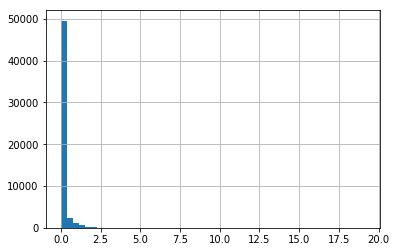

In [206]:
dataset.diff_TL.hist(bins=50)

In [467]:
thres = (1.5 * (dataset.diff_TL.quantile(0.75) - dataset.diff_TL.quantile(0.25))) + dataset.diff_TL.quantile(0.75)
thres, dataset.diff_TL.quantile(0.75), dataset.diff_TL.quantile(0.9)

(0.0007570404989692839, 0.0003028161997410287, 8.218295417905171)

In [468]:
len(dataset), len(dataset[dataset.diff_TL > 8.22])

(54191, 5417)

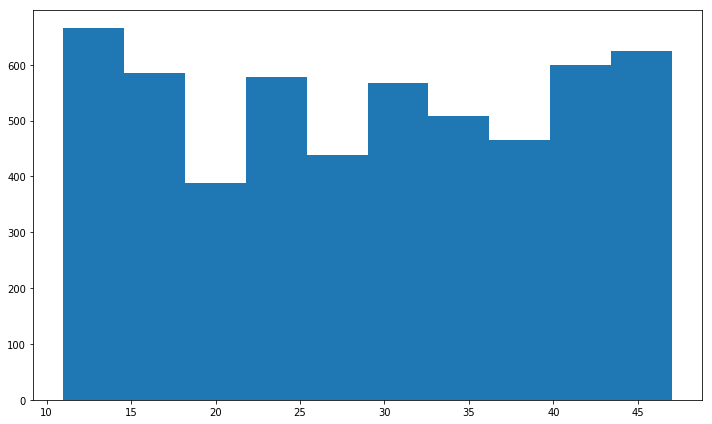

In [469]:
to_check = dataset[dataset.diff_TL > 8.21].copy()
to_check.hour_half.hist(grid=False, figsize=(10, 6))
plt.tight_layout()
plt.savefig('hourhist.png')

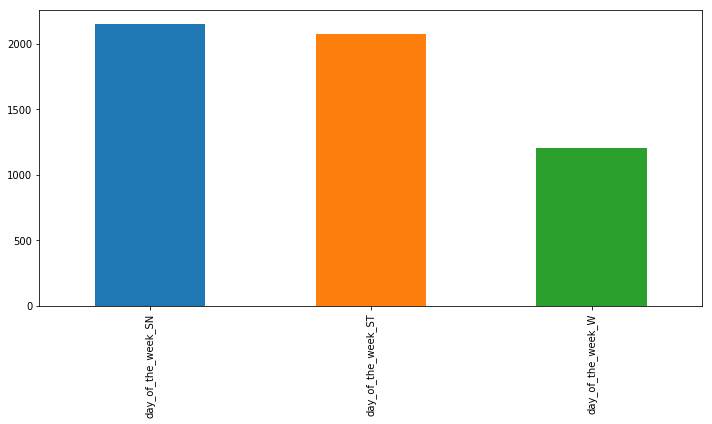

In [470]:
to_check[to_check.columns[:3]].sum(axis=0).plot(kind='bar',  figsize=(10, 6))
plt.tight_layout()
plt.savefig('bar1.png')

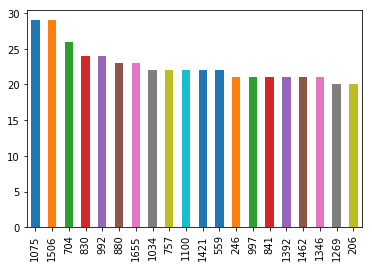

In [211]:
to_check.cell_number.value_counts()[:20].plot(kind='bar')
strange_cells = to_check.cell_number.value_counts()[:20].index.values

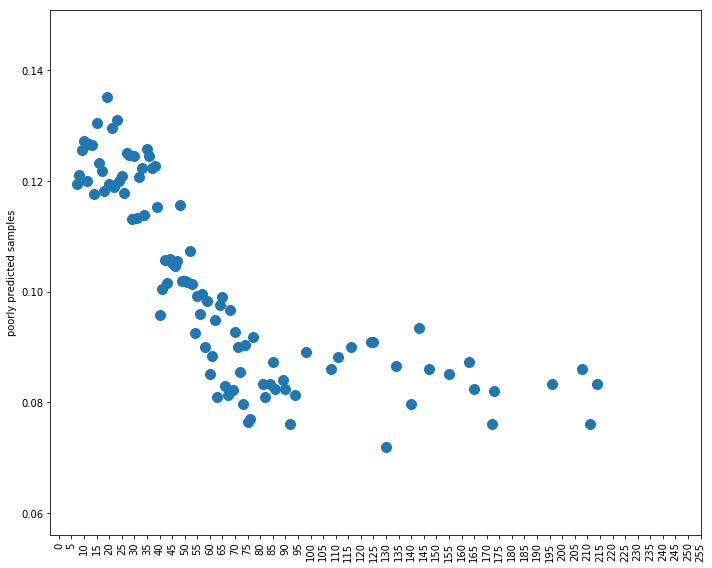

In [472]:
figure(figsize=(10, 8))
plt.scatter(to_check.n_cars.value_counts()[:100].index.values, to_check.n_cars.value_counts()[:100].values / tot_car_values,
           s=100)
plt.ylabel('poorly predicted samples')
plt.xticks(range(0, 260, 5), rotation=90);
plt.tight_layout()
plt.savefig('bar2.png')

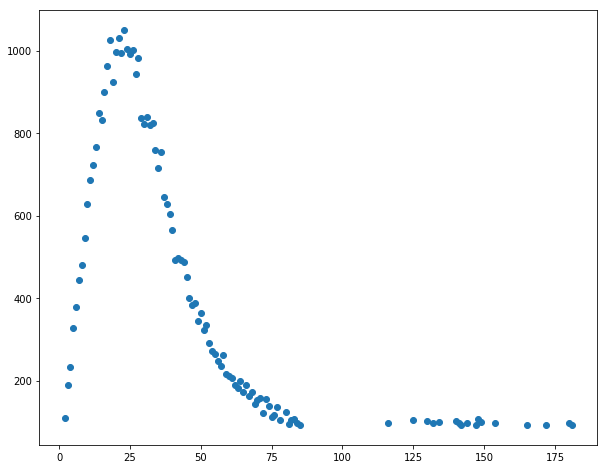

In [287]:
figure(figsize=(10, 8))
plt.scatter(dataset.n_cars.value_counts()[:100].index, dataset.n_cars.value_counts()[:100])
tot_car_values = dataset.n_cars.value_counts()[:100]

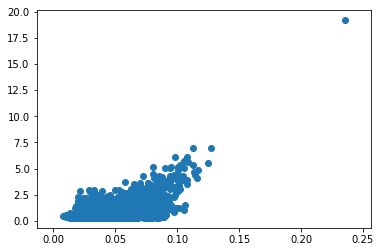

In [213]:
plt.scatter(to_check.TL.values, to_check.diff_TL.values)

In [306]:
stacked = dataset.iloc[:, :3].stack()
stacked = stacked[stacked == 1].reset_index(level=1)['level_1']
stacked = stacked.apply(lambda s: s[-2:])
pd.concat((dataset.iloc[:, [3,4,5, 11, 12, 13]], stacked), axis=1).rename(columns=
                                                                          {'level_1': 'weekday'}).to_csv('raw_values', index=False)

In [308]:
dataset[['TL', 'TL_pred']].describe()

,TL,TL_pred
count,54191.000000,54191.000000
mean,0.040548,0.040453
std,0.018298,0.017959
min,0.007582,0.007582
25%,0.028261,0.028466
50%,0.040678,0.040878
75%,0.052207,0.051967
max,0.352021,0.352021


In [214]:
plt.scatter(to_check.diff_TL.values, to_check.speed)

,day_of_the_week_SN,day_of_the_week_ST,day_of_the_week_W,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,TL,TL_pred,diff_TL
2524,1,0,0,16,45.02375,7.6325,0.04603,0.041451,284,17,4.245098,0.235566,0.043997,19.156902


10839
0.007758620689655172 0.0072203833


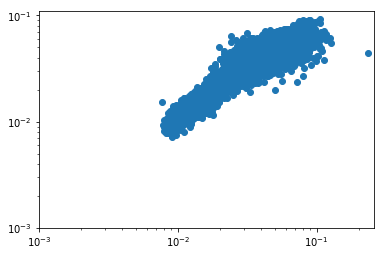

In [116]:
plt.scatter(y_test, model.predict(scaler.transform(X_test))/100)
plt.ylim(1e-3, )
plt.xlim(1e-3, )
plt.loglog()
print(len(X_test))
print(y_test.min(), (model.predict(scaler.transform(X_test))/100).min())

In [ ]:
val_losses = []
model_names = []

for h1 in range(15, 85, 5):
    for h2 in range(15, 100, 5):
        for is_h3 in [True, False]:
            for is_h4 in [True, False]:
                
                model = Sequential()
                model.add(Dense(h1, input_shape=(8, ), activation='relu'))
                model.add(Dense(h2, activation='relu'))
                if is_h3:
                    for h3 in range(3, 11):
                        model.add(Dense(h3, activation='relu'))
                        if is_h4:
                            for h4 in range(3, 11):
                                model.add(Dense(h4, activation='relu'))
                                model.add(Dense(1, ))
                                model.compile(loss='mean_squared_error', optimizer='adam')
                                v, n = practical_function(model, h1, h2, h3, h4)
                                val_losses.append(v)
                                model_names.append(n)
                        else:
                            model.add(Dense(1, ))
                            model.compile(loss='mean_squared_error', optimizer='adam')
                            v, n = practical_function(model, h1, h2, h3)
                            val_losses.append(v)
                            model_names.append(n)
                else:
                    model.add(Dense(1, ))
                    model.compile(loss='mean_squared_error', optimizer='adam')
                    v, n = practical_function(model, h1, h2)
                    val_losses.append(v)
                    model_names.append(n)    

In [386]:
def practical_function(model, h1, h2, h3=0, h4=0):
    filepath = 'neural_nets/weights_%d_%d_%d_%d.hdf5' % (h1, h2, h3, h4)
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, 
                                 save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    hist = model.fit(X_trans, y_train*100, validation_split=0.2,
              epochs=120, batch_size=128, callbacks=callbacks_list, verbose=0)
                                
    model_json = model.to_json()
    modelpath = 'neural_nets/model_%d_%d_%d_%d.json' % (h1, h2, h3, h4)
    with open(modelpath, "w") as json_file:
        json_file.write(model_json)
    print(h1, h2, h3, h4)
    return min(hist.history['val_loss']), modelpath[12:]

In [376]:
# serialize model to JSON
model_json = model.to_json()
with open("neural_nets/random_try.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("neural_nets/random_try.hdf5")
print("Saved model to disk")

Saved model to disk


In [379]:
# load json and create model
json_file = open('neural_nets/random_try.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("neural_nets/random_try.hdf5")
print("Loaded model from disk")

Loaded model from disk


Text(0.5,1,'Median trip length per day hour')

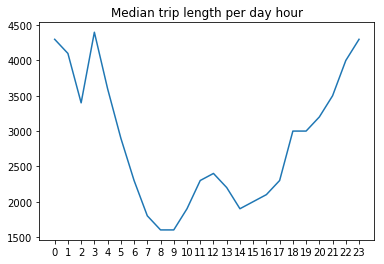

In [25]:
#fig = plt.figure(figsize=(20, 30))
#axes = fig.subplots(6, 4)
median_trip = []
for h in range(24):
    #i = h//4
    #j = h%4
    median_trip.append(turin_june[(turin_june.engine_status == 2) & (turin_june.hour == h)].meters.quantile(0.5))
    #.plot(kind='hist', ax=axes[i, j], #bins=15)
    
plt.plot(range(24), median_trip)
plt.xticks(range(24))
plt.title('Median trip length per day hour')

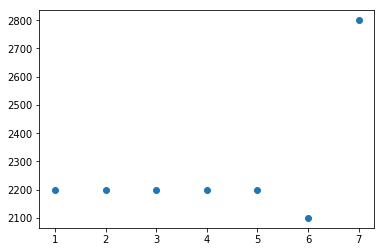

In [129]:
median_day_trip = []
for d in range(1, 8):
    median_day_trip.append(turin_june[(turin_june.engine_status == 2) &
                                  (turin_june.day_of_the_week == d)].meters.quantile(0.5))
    
plt.scatter(range(1, 8), median_day_trip)

In [ ]:
## Look at the trips

stop_coords = turin_june.loc[turin_june.engine_status == 1, ['lat', 'lon']].values

In [ ]:
plt.scatter(stop_coords[:, 1], stop_coords[:, 0])

In [149]:
from gmplot import gmplot

In [153]:
# Place map
gmap = gmplot.GoogleMapPlotter(45.07, 7.67, 13)


gmap.scatter(stop_coords[:10, 0], stop_coords[:10, 1], '#3B0B39', size=10, marker=False)

# Draw
gmap.draw("my_map.html")

In [94]:
a, b = st

In [66]:
coords = turin_june[turin_june.engine_status == 1].loc[:, ['lon', 'lat']].values

In [67]:
ti

array([[ 7.579479, 45.099049],
       [ 7.598485, 45.104286],
       [ 7.613513, 45.110054],
       ...,
       [ 7.636   , 45.115135],
       [ 7.636302, 45.115623],
       [ 7.636322, 45.11565 ]])

In [148]:
turin_june['hour_&_quarter'].unique()

array([datetime.time(6, 45), datetime.time(10, 30), datetime.time(10, 45),
       datetime.time(11, 45), datetime.time(12, 0), datetime.time(17, 45),
       datetime.time(18, 0), datetime.time(16, 45), datetime.time(17, 0),
       datetime.time(17, 15), datetime.time(20, 30),
       datetime.time(20, 45), datetime.time(6, 30), datetime.time(19, 0),
       datetime.time(19, 15), datetime.time(7, 0), datetime.time(18, 45),
       datetime.time(15, 30), datetime.time(11, 30),
       datetime.time(19, 30), datetime.time(6, 15), datetime.time(11, 0),
       datetime.time(4, 30), datetime.time(9, 30), datetime.time(9, 45),
       datetime.time(8, 30), datetime.time(16, 15), datetime.time(18, 30),
       datetime.time(12, 15), datetime.time(11, 15),
       datetime.time(18, 15), datetime.time(15, 45),
       datetime.time(17, 30), datetime.time(14, 0), datetime.time(14, 15),
       datetime.time(10, 15), datetime.time(15, 0), datetime.time(15, 15),
       datetime.time(4, 45), datetime.time(5

In [23]:
turin_june

,device_id,recording_date,lat,lon,speed,heading,gps_quality,engine_status,acceleration,meters,day,day_of_the_week,hour,hour_&_quarter
0,3100010,2017-06-01 06:45:38,45.099049,7.579479,103,68,8,1,0,14200,2017-06-01,4,6,06:45:00
1,3100010,2017-06-01 06:46:38,45.104286,7.598485,109,68,8,1,0,15800,2017-06-01,4,6,06:45:00
2,3100010,2017-06-01 06:47:19,45.110054,7.613513,122,56,8,1,0,17200,2017-06-01,4,6,06:45:00
3,3100010,2017-06-01 06:47:23,45.110573,7.614595,123,56,8,1,0,17300,2017-06-01,4,6,06:45:00
4,3100010,2017-06-01 06:47:38,45.113396,7.620533,128,56,8,1,0,17800,2017-06-01,4,6,06:45:00
5,3100010,2017-06-01 06:48:34,45.117565,7.637709,57,176,8,1,3,19400,2017-06-01,4,6,06:45:00
6,3100010,2017-06-01 06:48:38,45.117226,7.637706,16,180,8,1,0,19400,2017-06-01,4,6,06:45:00
7,3100010,2017-06-01 06:48:40,45.117191,7.637701,12,180,8,1,2,19500,2017-06-01,4,6,06:45:00
8,3100010,2017-06-01 06:48:59,45.115688,7.637361,35,266,8,1,3,19600,2017-06-01,4,6,06:45:00
9,3100010,2017-06-01 06:49:38,45.115749,7.635075,0,0,11,1,0,19800,2017-06-01,4,6,06:45:00


In [316]:
turin_june.cell_centroid_lat.min(), turin_june.cell_centroid_lat.max(), turin_june.cell_centroid_lon.min(), turin_june.cell_centroid_lon.max()

(45.00625, 45.14125, 7.5775000000000015, 7.7725)

In [390]:
newdat = pd.read_csv('raw_values.csv', usecols=['weekday'])
dataset['weekday'] = newdat.weekday.values

/Users/stefanocalde/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [407]:
colms = dataset.columns.tolist()[:11] + ['weekday']
colms

['day_of_the_week_SN',
 'day_of_the_week_ST',
 'day_of_the_week_W',
 'hour_half',
 'cell_centroid_lat',
 'cell_centroid_lon',
 'tl_neighs',
 'tl_prev_half',
 'cell_number',
 'n_cars',
 'speed',
 'weekday']

In [438]:
## Try two other things
import numpy as np

dataset_11 = dataset[dataset.hour_half == 11].copy()
cut_dataset = dataset[dataset.hour_half != 11][colms].copy()
cut_dataset.tl_neighs = np.nan
cut_dataset.tl_prev_half = np.nan

bad_cells = []
for d in ['SN', 'ST', 'W']:
    for h in range(12, 48):
        for c in dataset_11.cell_number.unique():
            if c in bad_cells:
                print(bad_cells)
                continue
            if h == 12:
                df = dataset_11
            else:
                df = cut_dataset.loc[cut_dataset.hour_half == h - 1]
         
            condition = (df.cell_number == c) & (df.weekday == d)
            check = 0
            if not len(df[condition]):
                bad_cells.append(c)
                continue
            n = find_neighbours(c)
            #print(n)
            condition2 = (df.cell_number.isin(n)) & (df.weekday == d) & (df.hour_half == h - 1)
            check = 0
            if not len(df[condition2]):
                bad_cells.append(c)
                continue
            #if not len(dataset[(dataset.cell_number == c) & (dataset.weekday == d) & (dataset.hour_half == h - 1)]):
                #continue
            #print(c)
            #print(h, df.loc[condition, df.columns[:8]])
            print(len(df[condition]))
            input_data = scaler2.transform(df.loc[condition, df.columns[:8]].values)
            prev_tl = np.power(np.e, extree.predict(input_data))
            if prev_tl >= 2:
                prev_tl = 1.98
            input_data2 = scaler2.transform(df.loc[condition2, df.columns[:8]].values)
            neighs_tl = np.mean(np.power(np.e, extree.predict(input_data2)))
            if neighs_tl >= 2:
                neighs_tl = 1.98
                
            #print(h, h, h)
            condition = (cut_dataset.cell_number == c) & (cut_dataset.weekday == d) & (cut_dataset.hour_half == h)
            cut_dataset.loc[condition, 'tl_neighs'] = neighs_tl
            cut_dataset.loc[condition, 'tl_prev_half'] = prev_tl
        print('Did hour %d' %h)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Did hour 12
1


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [437]:
cut_dataset[cut_dataset.cell_number == 46]

,day_of_the_week_SN,day_of_the_week_ST,day_of_the_week_W,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,weekday
494,1,0,0,12,45.00875,7.6125,0.015881,0.009088,46,15,112.266667,SN
993,1,0,0,13,45.00875,7.6125,NaN,NaN,46,12,91.055556,SN
1493,1,0,0,14,45.00875,7.6125,NaN,NaN,46,19,100.210526,SN
1993,1,0,0,15,45.00875,7.6125,NaN,NaN,46,19,99.894737,SN
2493,1,0,0,16,45.00875,7.6125,NaN,NaN,46,26,98.634615,SN
2993,1,0,0,17,45.00875,7.6125,NaN,NaN,46,39,96.027778,SN
3493,1,0,0,18,45.00875,7.6125,NaN,NaN,46,39,100.444444,SN
3993,1,0,0,19,45.00875,7.6125,NaN,NaN,46,28,92.035714,SN
4493,1,0,0,20,45.00875,7.6125,NaN,NaN,46,35,106.238095,SN
4993,1,0,0,21,45.00875,7.6125,NaN,NaN,46,25,97.420000,SN


In [394]:
r2_score(y_test, extree.predict(scaler2.transform(X_test)))

0.9172046766466174

In [381]:
scaler2 = MinMaxScaler().fit(X_train)

In [395]:
from sklearn.externals import joblib
joblib.dump(scaler2, 'scaler_minmax.pkl') 
joblib.dump(extree, 'regressor.pkl') 

['regressor.pkl']

In [398]:
dataset.describe()

,day_of_the_week_SN,day_of_the_week_ST,day_of_the_week_W,hour_half,cell_centroid_lat,cell_centroid_lon,tl_neighs,tl_prev_half,cell_number,n_cars,speed,TL,TL_pred,diff_TL
count,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,54191.000000,5.419100e+04
mean,0.320717,0.337897,0.341385,29.057611,45.071561,7.661910,0.040894,0.040652,1035.729106,84.597461,33.294754,0.040548,0.040453,9.801722e-02
std,0.466757,0.472998,0.474179,10.478437,0.029332,0.035133,0.015929,0.020826,459.881762,96.846761,23.356890,0.018298,0.017959,3.334524e-01
min,0.000000,0.000000,0.000000,11.000000,45.008750,7.577500,0.007812,0.007246,46.000000,7.000000,2.840741,0.007582,0.007582,0.000000e+00
25%,0.000000,0.000000,0.000000,20.000000,45.051250,7.637500,0.032867,0.028175,712.000000,23.000000,19.154597,0.028261,0.028466,8.437695e-15
50%,0.000000,0.000000,0.000000,29.000000,45.071250,7.662500,0.043111,0.040665,1039.000000,40.000000,24.583333,0.040678,0.040878,1.865175e-14
75%,1.000000,1.000000,1.000000,38.000000,45.093750,7.687500,0.050570,0.052242,1393.000000,119.000000,35.384984,0.052207,0.051967,1.229227e-05
max,1.000000,1.000000,1.000000,47.000000,45.138750,7.767500,0.527378,2.000000,2100.000000,762.000000,131.888889,0.352021,0.352021,1.915690e+01
